# Previsão de Inadimplência de Clientes

A inadimplência é um dos maiores desafios enfrentados por empresas que oferecem crédito ou realizam cobranças periódicas. Quando um cliente atrasa ou deixa de pagar uma obrigação financeira, a empresa não apenas perde receita, como também compromete o fluxo de caixa, aumenta seus custos operacionais com cobrança e eleva o risco financeiro da operação.

Além disso, altos índices de inadimplência podem indicar problemas na concessão de crédito, falhas no relacionamento com o cliente ou mesmo reflexos de instabilidades econômicas. Identificar com antecedência os clientes que têm maior chance de atrasar seus pagamentos permite ações mais eficientes, como contato proativo, renegociação ou revisão de limites de crédito.

Diante disso, algumas perguntas importantes surgem:

- Quais características dos clientes estão mais associadas à inadimplência?
- É possível prever a inadimplência antes que o atraso ocorra?
- Existe um padrão comportamental que antecede o não pagamento?
- Como transformar essas informações em ações práticas para reduzir perdas?

Neste projeto, será desenvolvida uma solução baseada em dados que visa prever a probabilidade de inadimplência em cobranças mensais realizadas a clientes, com base em seus históricos de pagamento, informações cadastrais e indicadores mensais.

O objetivo final é permitir que a empresa possa priorizar ações de cobrança de forma mais inteligente e eficiente, reduzindo riscos e melhorando seus resultados financeiros.

## 1 - Importação das bibliotecas necessárias

In [1]:
# Importação das bibliotecas 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from dateutil.relativedelta import relativedelta
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix

# 2 - Pré-processamento dos dados

In [2]:
# Leitura e visualização de algumas informações dos dados

# informações de cadastro
cadastros = pd.read_csv('data/base_cadastral.csv', parse_dates=["DATA_CADASTRO"],
                        sep=';')
cadastros.info()
print(f'\nNúmero de linhas duplicadas: {cadastros.duplicated().sum()}\n')

# informações sobre os clientes

infos = pd.read_csv('data/base_info.csv', parse_dates=["SAFRA_REF"], sep=';')
infos.info()
print(f'\nNúmero de linhas duplicadas: {infos.duplicated().sum()}\n')

# base de pagamentos (desenvolvimento)

pagamentos_dev = pd.read_csv('data/base_pagamentos_desenvolvimento.csv', parse_dates=["DATA_EMISSAO_DOCUMENTO", "DATA_VENCIMENTO", 
                                                                                      "DATA_PAGAMENTO", "SAFRA_REF"],
                             sep=';')
pagamentos_dev.info()
print(f'\nNúmero de linhas duplicadas: {pagamentos_dev.duplicated().sum()}\n')

# base de pagamentos (teste)
pagamentos_teste = pd.read_csv('data/base_pagamentos_teste.csv', parse_dates=["DATA_EMISSAO_DOCUMENTO", "DATA_VENCIMENTO", "SAFRA_REF"],
                               sep=';')
pagamentos_teste.info()
print(f'\nNúmero de linhas duplicadas: {pagamentos_teste.duplicated().sum()}\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_CLIENTE           1315 non-null   int64         
 1   DATA_CADASTRO        1315 non-null   datetime64[ns]
 2   DDD                  1078 non-null   object        
 3   FLAG_PF              66 non-null     object        
 4   SEGMENTO_INDUSTRIAL  1232 non-null   object        
 5   DOMINIO_EMAIL        1285 non-null   object        
 6   PORTE                1274 non-null   object        
 7   CEP_2_DIG            1315 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 82.3+ KB

Número de linhas duplicadas: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24401 entries, 0 to 24400
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 

Observando as informações sobre os dados, podemos chegar às seguintes conclusões:

1- Para a base com informações de cadastro (**base_cadastral.csv**), podemos observar:
- Muitos valores nulos na coluna `FLAG_PF`, porém, já era de se esperar, pois os clientes que são do tipo PJ estão marcados com a flag de valor nulo, ao contrário dos clientes do tipo PF, que têm valor atribuído. A coluna então será reformulada para ter valores 1 para PF e 0 para PJ;
-  Valores nulos na coluna `DDD`, que possui importância por trazer informações sobre localização geográfica do cliente através do DDD, que pode se mostrar importante na análise de possível inadimplência. Nesse caso, os valores nulos serão preenchidos com 'OUTRO';
- Valores nulos nas colunas `SEGMENTO_INDUSTRIAL`, `DOMINIO_EMAIL` e `PORTE` serão também substituídos por 'OUTRO', preservando registros que, mesmo incompletos, podem conter informações relevantes para o aprendizado do modelo;
- Como não há linhas duplicadas, nada será feito em relação a isso;

2- Para a base com informações adicionais sobre o cliente (**base_info.csv**), podemos observar:
- Valores nulos na coluna `RENDA_MES_ANTERIOR`, que contem informações importantes para previsão de inadimplência. As informações faltantes serão preenchidas com a mediana das rendas históricas do próprio cliente, reduzindo o impacto de outliers. Caso o cliente não possua registros suficientes para o cálculo da mediana, a informação sobre a renda mensal será preenchida com 0. A ausência dos valores será marcada com uma coluna flag `RENDA_MES_ANTERIOR_NULO` para marcar a ausência de informação;
- Valores nulos na coluna `NO_FUNCIONARIOS`, que, considerando o contexto da base cadastral, podem estar associados a clientes do tipo PF. Esses valores serão preenchidos com 0 e será criada uma flag `NO_FUNCIONARIOS_NULO` para sinalizar os registros originalmente ausentes, permitindo ao modelo capturar possíveis implicações.

3- Para as base de treinamento e teste com as informações de pagamentos (**base_pagamentos_desenvolvimento.csv**), podemos observar:
- Valores ausentes na coluna `VALOR_A_PAGAR` indicam uma inconsistência preocupante, já que esse valor é fundamental para compreender o risco de inadimplência. Essa ausência pode ter origem em falha na geração da base ou em outra causa operacional. Independentemente da razão, os valores nulos serão preenchidos com a mediana dos valores cobrados ao cliente específico — a fim de manter consistência com o padrão individual de cobrança. Na ausência de histórico suficiente, será usado o valor 0. Além disso, será criada a coluna `VALOR_A_PAGAR_NULO`, sinalizando que aquela cobrança possui dado ausente. Essa abordagem permite que o modelo diferencie registros típicos de casos com possível problema de origem;
- Em ambas as bases observamos linhas completamente idênticas. Como representam registros idênticos, e não adicionam valor ao aprendizado, serão removidas para evitar viés ou sobre-representação de determinados padrões;


In [3]:
## Ajuste da base de cadastros

# ajuste da coluna FLAG_PF

cadastros['FLAG_PF'] = np.where(cadastros['FLAG_PF'] == 'X',
                                1,
                                0).astype('int64')
# ajuste das demais colunas
cadastros[['DDD', 'SEGMENTO_INDUSTRIAL', 
           'DOMINIO_EMAIL', 'PORTE']] = cadastros[['DDD', 'SEGMENTO_INDUSTRIAL', 
                                                   'DOMINIO_EMAIL', 'PORTE']].fillna('OUTROS')

cadastros[['DDD', 'SEGMENTO_INDUSTRIAL', 
           'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG']] = cadastros[['DDD', 'SEGMENTO_INDUSTRIAL', 
                                                                'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG']].astype('category')
cadastros.info()
cadastros.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_CLIENTE           1315 non-null   int64         
 1   DATA_CADASTRO        1315 non-null   datetime64[ns]
 2   DDD                  1315 non-null   category      
 3   FLAG_PF              1315 non-null   int64         
 4   SEGMENTO_INDUSTRIAL  1315 non-null   category      
 5   DOMINIO_EMAIL        1315 non-null   category      
 6   PORTE                1315 non-null   category      
 7   CEP_2_DIG            1315 non-null   category      
dtypes: category(5), datetime64[ns](1), int64(2)
memory usage: 43.5 KB


,ID_CLIENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
0,1661240395903230676,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65
1,8274986328479596038,2017-01-25,31,0,Comércio,YAHOO,MEDIO,77
2,345447888460137901,2000-08-15,75,0,Serviços,HOTMAIL,PEQUENO,48
3,1003144834589372198,2017-08-06,49,0,Serviços,OUTLOOK,PEQUENO,89
4,324916756972236008,2011-02-14,88,0,Serviços,GMAIL,GRANDE,62
5,4679462479444735708,2000-08-15,18,0,Indústria,HOTMAIL,GRANDE,19
6,1276604410881911401,2000-08-15,67,0,Indústria,YAHOO,PEQUENO,38
7,8123515208041701633,2011-02-14,21,0,Serviços,GMAIL,PEQUENO,26
8,4530631557358349711,2000-08-15,11,0,Serviços,HOTMAIL,PEQUENO,55
9,3668905663669864663,2011-02-14,44,0,Comércio,BOL,GRANDE,87


In [4]:
# geração de coluna reutilizável para preenchimento de valores nulos
def preencher_com_mediana_por_cliente(df, coluna, criar_flag=True):
    """
    Preenche valores nulos de uma coluna numérica com a mediana por ID_CLIENTE.
    Se o cliente não tiver mediana disponível, preenche com a mediana geral da coluna.
    
    Parâmetros:
    - df (pd.DataFrame): DataFrame de entrada (deve conter 'ID_CLIENTE')
    - coluna (str): nome da coluna numérica a ser preenchida
    - criar_flag (bool): se True, cria uma coluna booleana {coluna}_NULO indicando valores originalmente ausentes
    
    Retorna:
    - df (pd.DataFrame): DataFrame com coluna preenchida e (opcionalmente) a flag de nulo
    """
    df = df.copy()

    # 1. Cria flag de valor ausente, se desejado
    if criar_flag:
        df[f'{coluna}_NULO'] = df[coluna].isna().astype('int64')
    
    # 2. Calcula a mediana da coluna por cliente
    mediana_por_cliente = df.groupby('ID_CLIENTE')[coluna].median()

    # 3. Mapeia a mediana para cada linha do DataFrame
    df[f'{coluna}_MEDIANA_CLIENTE'] = df['ID_CLIENTE'].map(mediana_por_cliente)

    # 4. Preenche os nulos com a mediana do cliente
    df[coluna] = df[coluna].fillna(df[f'{coluna}_MEDIANA_CLIENTE'])

    # 5. Preenche valores ainda nulos com 0
    df[coluna] = df[coluna].fillna(0)

    # 6. Remove a coluna auxiliar
    df = df.drop(columns=[f'{coluna}_MEDIANA_CLIENTE'])

    return df

In [5]:
## Ajuste da base com informações dos clientes

infos = preencher_com_mediana_por_cliente(infos, 'RENDA_MES_ANTERIOR')
infos['NO_FUNCIONARIOS_NULO'] = infos['NO_FUNCIONARIOS'].isna().astype('int64')
infos['NO_FUNCIONARIOS'] = infos['NO_FUNCIONARIOS'].fillna(0)

infos.info()
infos.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24401 entries, 0 to 24400
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID_CLIENTE               24401 non-null  int64         
 1   SAFRA_REF                24401 non-null  datetime64[ns]
 2   RENDA_MES_ANTERIOR       24401 non-null  float64       
 3   NO_FUNCIONARIOS          24401 non-null  float64       
 4   RENDA_MES_ANTERIOR_NULO  24401 non-null  int64         
 5   NO_FUNCIONARIOS_NULO     24401 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 1.1 MB


,ID_CLIENTE,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,RENDA_MES_ANTERIOR_NULO,NO_FUNCIONARIOS_NULO
0,1661240395903230676,2018-09-01,16913.0,0.0,0,1
1,8274986328479596038,2018-09-01,106430.0,141.0,0,0
2,345447888460137901,2018-09-01,707439.0,99.0,0,0
3,1003144834589372198,2018-09-01,239659.0,96.0,0,0
4,324916756972236008,2018-09-01,203123.0,103.0,0,0
5,4679462479444735708,2018-09-01,53021.0,120.0,0,0
6,1276604410881911401,2018-09-01,97117.0,79.0,0,0
7,8123515208041701633,2018-09-01,142410.0,72.0,0,0
8,4530631557358349711,2018-09-01,185040.0,101.0,0,0
9,3668905663669864663,2018-09-01,331138.0,137.0,0,0


In [6]:
## Ajuste da base de pagamentos (desenvolvimento)

pagamentos_dev = preencher_com_mediana_por_cliente(pagamentos_dev, 'VALOR_A_PAGAR')
pagamentos_dev.drop_duplicates(inplace=True)

pagamentos_dev.info()
pagamentos_dev.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 77413 entries, 0 to 77413
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID_CLIENTE              77413 non-null  int64         
 1   SAFRA_REF               77413 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO  77413 non-null  datetime64[ns]
 3   DATA_PAGAMENTO          77413 non-null  datetime64[ns]
 4   DATA_VENCIMENTO         77413 non-null  datetime64[ns]
 5   VALOR_A_PAGAR           77413 non-null  float64       
 6   TAXA                    77413 non-null  float64       
 7   VALOR_A_PAGAR_NULO      77413 non-null  int64         
dtypes: datetime64[ns](4), float64(2), int64(2)
memory usage: 5.3 MB


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,VALOR_A_PAGAR_NULO
0,1661240395903230676,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0
1,1661240395903230676,2018-08-01,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,0
2,1661240395903230676,2018-08-01,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,0
3,1661240395903230676,2018-08-01,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,0
4,1661240395903230676,2018-08-01,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,0
5,8274986328479596038,2018-08-01,2018-08-17,2018-09-25,2018-09-25,48811.35,6.99,0
6,345447888460137901,2018-08-01,2018-08-17,2018-09-05,2018-09-05,55131.20,5.99,0
7,1003144834589372198,2018-08-01,2018-08-17,2018-09-03,2018-09-03,85855.04,6.99,0
8,324916756972236008,2018-08-01,2018-08-17,2018-09-03,2018-09-03,42072.00,5.99,0
9,324916756972236008,2018-08-01,2018-08-19,2018-09-05,2018-09-05,21071.97,5.99,0


In [7]:
## Ajuste da base de pagamentos (teste)

pagamentos_teste = preencher_com_mediana_por_cliente(pagamentos_teste, 'VALOR_A_PAGAR')
pagamentos_teste.drop_duplicates(inplace=True)

pagamentos_teste.info()
pagamentos_teste.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 12264 entries, 0 to 12274
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID_CLIENTE              12264 non-null  int64         
 1   SAFRA_REF               12264 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO  12264 non-null  datetime64[ns]
 3   DATA_VENCIMENTO         12264 non-null  datetime64[ns]
 4   VALOR_A_PAGAR           12264 non-null  float64       
 5   TAXA                    12264 non-null  float64       
 6   VALOR_A_PAGAR_NULO      12264 non-null  int64         
dtypes: datetime64[ns](3), float64(2), int64(2)
memory usage: 766.5 KB


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,VALOR_A_PAGAR_NULO
0,5058298901476893676,2021-07-01,2021-07-14,2021-08-04,11204.75,4.99,0
1,274692171162531764,2021-07-01,2021-07-08,2021-08-23,60718.50,5.99,0
2,274692171162531764,2021-07-01,2021-07-11,2021-08-25,60718.50,5.99,0
3,274692171162531764,2021-07-01,2021-07-16,2021-08-30,62250.00,5.99,0
4,465309249432033993,2021-07-01,2021-07-05,2021-07-30,26593.95,6.99,0
5,465309249432033993,2021-07-01,2021-07-09,2021-08-03,26012.44,6.99,0
6,465309249432033993,2021-07-01,2021-07-13,2021-08-09,26082.54,6.99,0
7,465309249432033993,2021-07-01,2021-07-13,2021-08-09,26738.12,6.99,0
8,5883155883105348987,2021-07-01,2021-07-03,2021-07-22,20260.27,8.99,0
9,5883155883105348987,2021-07-01,2021-07-08,2021-07-26,19043.82,8.99,0


In [8]:
# adição da coluna alvo na base de treinamento

pagamentos_dev['INADIMPLENTE'] = np.where((pagamentos_dev['DATA_PAGAMENTO'] - pagamentos_dev['DATA_VENCIMENTO']).dt.days >= 5,
                                          1,
                                          0).astype('int64') # 1 para inadimplente, 0 para adimplente

pagamentos_dev.info()
pagamentos_dev.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 77413 entries, 0 to 77413
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID_CLIENTE              77413 non-null  int64         
 1   SAFRA_REF               77413 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO  77413 non-null  datetime64[ns]
 3   DATA_PAGAMENTO          77413 non-null  datetime64[ns]
 4   DATA_VENCIMENTO         77413 non-null  datetime64[ns]
 5   VALOR_A_PAGAR           77413 non-null  float64       
 6   TAXA                    77413 non-null  float64       
 7   VALOR_A_PAGAR_NULO      77413 non-null  int64         
 8   INADIMPLENTE            77413 non-null  int64         
dtypes: datetime64[ns](4), float64(2), int64(3)
memory usage: 5.9 MB


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,VALOR_A_PAGAR_NULO,INADIMPLENTE
0,1661240395903230676,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,0
1,1661240395903230676,2018-08-01,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,0,0
2,1661240395903230676,2018-08-01,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,0,0
3,1661240395903230676,2018-08-01,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,0,1
4,1661240395903230676,2018-08-01,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,0,0
5,8274986328479596038,2018-08-01,2018-08-17,2018-09-25,2018-09-25,48811.35,6.99,0,0
6,345447888460137901,2018-08-01,2018-08-17,2018-09-05,2018-09-05,55131.20,5.99,0,0
7,1003144834589372198,2018-08-01,2018-08-17,2018-09-03,2018-09-03,85855.04,6.99,0,0
8,324916756972236008,2018-08-01,2018-08-17,2018-09-03,2018-09-03,42072.00,5.99,0,0
9,324916756972236008,2018-08-01,2018-08-19,2018-09-05,2018-09-05,21071.97,5.99,0,0


In [9]:
# gerando base de dados final para treinamento do modelo

base_dev = pagamentos_dev.merge(cadastros, 
                                on='ID_CLIENTE',
                                how='left').drop_duplicates().merge(infos,
                                                  on=['ID_CLIENTE', 'SAFRA_REF'],
                                                  how='left').drop_duplicates()

base_dev.info()
base_dev.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77413 entries, 0 to 77412
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID_CLIENTE               77413 non-null  int64         
 1   SAFRA_REF                77413 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO   77413 non-null  datetime64[ns]
 3   DATA_PAGAMENTO           77413 non-null  datetime64[ns]
 4   DATA_VENCIMENTO          77413 non-null  datetime64[ns]
 5   VALOR_A_PAGAR            77413 non-null  float64       
 6   TAXA                     77413 non-null  float64       
 7   VALOR_A_PAGAR_NULO       77413 non-null  int64         
 8   INADIMPLENTE             77413 non-null  int64         
 9   DATA_CADASTRO            77413 non-null  datetime64[ns]
 10  DDD                      77413 non-null  category      
 11  FLAG_PF                  77413 non-null  int64         
 12  SEGMENTO_INDUSTRIAL      77413 n

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,VALOR_A_PAGAR_NULO,INADIMPLENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,RENDA_MES_ANTERIOR_NULO,NO_FUNCIONARIOS_NULO
0,1661240395903230676,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,0,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65,NaN,NaN,NaN,NaN
1,1661240395903230676,2018-08-01,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,0,0,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65,NaN,NaN,NaN,NaN
2,1661240395903230676,2018-08-01,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,0,0,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65,NaN,NaN,NaN,NaN
3,1661240395903230676,2018-08-01,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,0,1,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65,NaN,NaN,NaN,NaN
4,1661240395903230676,2018-08-01,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,0,0,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65,NaN,NaN,NaN,NaN
5,8274986328479596038,2018-08-01,2018-08-17,2018-09-25,2018-09-25,48811.35,6.99,0,0,2017-01-25,31,0,Comércio,YAHOO,MEDIO,77,NaN,NaN,NaN,NaN
6,345447888460137901,2018-08-01,2018-08-17,2018-09-05,2018-09-05,55131.20,5.99,0,0,2000-08-15,75,0,Serviços,HOTMAIL,PEQUENO,48,NaN,NaN,NaN,NaN
7,1003144834589372198,2018-08-01,2018-08-17,2018-09-03,2018-09-03,85855.04,6.99,0,0,2017-08-06,49,0,Serviços,OUTLOOK,PEQUENO,89,NaN,NaN,NaN,NaN
8,324916756972236008,2018-08-01,2018-08-17,2018-09-03,2018-09-03,42072.00,5.99,0,0,2011-02-14,88,0,Serviços,GMAIL,GRANDE,62,NaN,NaN,NaN,NaN
9,324916756972236008,2018-08-01,2018-08-19,2018-09-05,2018-09-05,21071.97,5.99,0,0,2011-02-14,88,0,Serviços,GMAIL,GRANDE,62,NaN,NaN,NaN,NaN


In [10]:
# gerando base de dados final para treinamento do modelo

base_teste = pagamentos_teste.merge(cadastros, 
                                on='ID_CLIENTE',
                                how='left').drop_duplicates().merge(infos,
                                                  on=['ID_CLIENTE', 'SAFRA_REF'],
                                                  how='left').drop_duplicates()

base_teste.info()
base_teste.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12264 entries, 0 to 12263
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID_CLIENTE               12264 non-null  int64         
 1   SAFRA_REF                12264 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO   12264 non-null  datetime64[ns]
 3   DATA_VENCIMENTO          12264 non-null  datetime64[ns]
 4   VALOR_A_PAGAR            12264 non-null  float64       
 5   TAXA                     12264 non-null  float64       
 6   VALOR_A_PAGAR_NULO       12264 non-null  int64         
 7   DATA_CADASTRO            12226 non-null  datetime64[ns]
 8   DDD                      12226 non-null  category      
 9   FLAG_PF                  12226 non-null  float64       
 10  SEGMENTO_INDUSTRIAL      12226 non-null  category      
 11  DOMINIO_EMAIL            12226 non-null  category      
 12  PORTE                    12226 n

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,VALOR_A_PAGAR_NULO,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,RENDA_MES_ANTERIOR_NULO,NO_FUNCIONARIOS_NULO
0,5058298901476893676,2021-07-01,2021-07-14,2021-08-04,11204.75,4.99,0,2014-03-30,54,0.0,Serviços,GMAIL,MEDIO,99,467430.0,0.0,0.0,1.0
1,274692171162531764,2021-07-01,2021-07-08,2021-08-23,60718.50,5.99,0,2005-08-03,19,0.0,Serviços,GMAIL,PEQUENO,13,417192.0,104.0,0.0,0.0
2,274692171162531764,2021-07-01,2021-07-11,2021-08-25,60718.50,5.99,0,2005-08-03,19,0.0,Serviços,GMAIL,PEQUENO,13,417192.0,104.0,0.0,0.0
3,274692171162531764,2021-07-01,2021-07-16,2021-08-30,62250.00,5.99,0,2005-08-03,19,0.0,Serviços,GMAIL,PEQUENO,13,417192.0,104.0,0.0,0.0
4,465309249432033993,2021-07-01,2021-07-05,2021-07-30,26593.95,6.99,0,2014-07-23,69,0.0,Comércio,GMAIL,GRANDE,76,873938.0,119.0,0.0,0.0
5,465309249432033993,2021-07-01,2021-07-09,2021-08-03,26012.44,6.99,0,2014-07-23,69,0.0,Comércio,GMAIL,GRANDE,76,873938.0,119.0,0.0,0.0
6,465309249432033993,2021-07-01,2021-07-13,2021-08-09,26082.54,6.99,0,2014-07-23,69,0.0,Comércio,GMAIL,GRANDE,76,873938.0,119.0,0.0,0.0
7,465309249432033993,2021-07-01,2021-07-13,2021-08-09,26738.12,6.99,0,2014-07-23,69,0.0,Comércio,GMAIL,GRANDE,76,873938.0,119.0,0.0,0.0
8,5883155883105348987,2021-07-01,2021-07-03,2021-07-22,20260.27,8.99,0,2011-02-14,11,0.0,Comércio,GMAIL,PEQUENO,42,471300.0,143.0,0.0,0.0
9,5883155883105348987,2021-07-01,2021-07-08,2021-07-26,19043.82,8.99,0,2011-02-14,11,0.0,Comércio,GMAIL,PEQUENO,42,471300.0,143.0,0.0,0.0


In [11]:
# observando um caso com valores nulos

nulos_dev_id = base_dev[base_dev['RENDA_MES_ANTERIOR'].isnull()]['ID_CLIENTE'].values[1]

print(pagamentos_dev[pagamentos_dev['ID_CLIENTE'] == nulos_dev_id]['SAFRA_REF'].unique())

print(infos[infos['ID_CLIENTE'] == nulos_dev_id]['SAFRA_REF'].unique())

<DatetimeArray>
['2018-08-01 00:00:00', '2018-09-01 00:00:00', '2018-10-01 00:00:00',
 '2018-11-01 00:00:00', '2018-12-01 00:00:00', '2019-01-01 00:00:00',
 '2019-02-01 00:00:00', '2019-03-01 00:00:00', '2019-04-01 00:00:00',
 '2019-05-01 00:00:00', '2019-06-01 00:00:00', '2019-07-01 00:00:00',
 '2019-08-01 00:00:00', '2019-09-01 00:00:00', '2019-10-01 00:00:00',
 '2019-11-01 00:00:00', '2019-12-01 00:00:00', '2020-01-01 00:00:00',
 '2020-02-01 00:00:00', '2020-04-01 00:00:00', '2020-05-01 00:00:00',
 '2020-06-01 00:00:00', '2020-07-01 00:00:00', '2020-08-01 00:00:00',
 '2020-09-01 00:00:00', '2020-10-01 00:00:00', '2020-11-01 00:00:00',
 '2020-12-01 00:00:00', '2021-01-01 00:00:00', '2021-02-01 00:00:00',
 '2021-03-01 00:00:00', '2021-04-01 00:00:00', '2021-05-01 00:00:00',
 '2021-06-01 00:00:00']
Length: 34, dtype: datetime64[ns]
<DatetimeArray>
['2018-09-01 00:00:00', '2018-10-01 00:00:00', '2018-11-01 00:00:00',
 '2018-12-01 00:00:00', '2019-01-01 00:00:00', '2019-02-01 00:00:00',


Apesar do preenchimento prévio dos valores ausentes nas bases originais, ainda foram identificados registros com valores nulos nas colunas `RENDA_MES_ANTERIOR` e `NO_FUNCIONARIOS` após a junção final das tabelas. Isso também se reflete nas flags associadas a essas variáveis, que permanecem com valores nulos.

Essa situação ocorre porque nem todos os meses com informações de pagamento têm correspondência na base de informações mensais — ou seja, existem casos em que o cliente possui uma cobrança registrada, mas não há informações disponíveis para aquele mês específico.

Diante disso, e seguindo as diretrizes já estabelecidas anteriormente, será reaplicada a lógica de preenchimento com a mediana por cliente (ou valor zero, quando necessário), garantindo consistência nos dados e evitando a exclusão de registros potencialmente úteis para a modelagem.

In [12]:
# ajustando a base de dados final de desenvolvimento

base_dev = preencher_com_mediana_por_cliente(base_dev, 'RENDA_MES_ANTERIOR')
base_dev['NO_FUNCIONARIOS_NULO'] = base_dev['NO_FUNCIONARIOS'].isna().astype('int64')
base_dev['NO_FUNCIONARIOS']= base_dev['NO_FUNCIONARIOS'].fillna(0)

base_dev.info()
base_dev.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77413 entries, 0 to 77412
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID_CLIENTE               77413 non-null  int64         
 1   SAFRA_REF                77413 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO   77413 non-null  datetime64[ns]
 3   DATA_PAGAMENTO           77413 non-null  datetime64[ns]
 4   DATA_VENCIMENTO          77413 non-null  datetime64[ns]
 5   VALOR_A_PAGAR            77413 non-null  float64       
 6   TAXA                     77413 non-null  float64       
 7   VALOR_A_PAGAR_NULO       77413 non-null  int64         
 8   INADIMPLENTE             77413 non-null  int64         
 9   DATA_CADASTRO            77413 non-null  datetime64[ns]
 10  DDD                      77413 non-null  category      
 11  FLAG_PF                  77413 non-null  int64         
 12  SEGMENTO_INDUSTRIAL      77413 n

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,VALOR_A_PAGAR_NULO,INADIMPLENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,RENDA_MES_ANTERIOR_NULO,NO_FUNCIONARIOS_NULO
0,1661240395903230676,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,0,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65,252109.0,0.0,1,1
1,1661240395903230676,2018-08-01,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,0,0,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65,252109.0,0.0,1,1
2,1661240395903230676,2018-08-01,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,0,0,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65,252109.0,0.0,1,1
3,1661240395903230676,2018-08-01,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,0,1,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65,252109.0,0.0,1,1
4,1661240395903230676,2018-08-01,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,0,0,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65,252109.0,0.0,1,1
5,8274986328479596038,2018-08-01,2018-08-17,2018-09-25,2018-09-25,48811.35,6.99,0,0,2017-01-25,31,0,Comércio,YAHOO,MEDIO,77,83013.0,0.0,1,1
6,345447888460137901,2018-08-01,2018-08-17,2018-09-05,2018-09-05,55131.20,5.99,0,0,2000-08-15,75,0,Serviços,HOTMAIL,PEQUENO,48,243615.0,0.0,1,1
7,1003144834589372198,2018-08-01,2018-08-17,2018-09-03,2018-09-03,85855.04,6.99,0,0,2017-08-06,49,0,Serviços,OUTLOOK,PEQUENO,89,275924.0,0.0,1,1
8,324916756972236008,2018-08-01,2018-08-17,2018-09-03,2018-09-03,42072.00,5.99,0,0,2011-02-14,88,0,Serviços,GMAIL,GRANDE,62,244012.0,0.0,1,1
9,324916756972236008,2018-08-01,2018-08-19,2018-09-05,2018-09-05,21071.97,5.99,0,0,2011-02-14,88,0,Serviços,GMAIL,GRANDE,62,244012.0,0.0,1,1


In [13]:
# ajustando a base de dados final de teste

base_teste = preencher_com_mediana_por_cliente(base_teste, 'RENDA_MES_ANTERIOR')
base_teste['NO_FUNCIONARIOS_NULO'] = base_teste['NO_FUNCIONARIOS'].isna().astype('int64')
base_teste['NO_FUNCIONARIOS']= base_teste['NO_FUNCIONARIOS'].fillna(0)

base_teste.info()
base_teste.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12264 entries, 0 to 12263
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID_CLIENTE               12264 non-null  int64         
 1   SAFRA_REF                12264 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO   12264 non-null  datetime64[ns]
 3   DATA_VENCIMENTO          12264 non-null  datetime64[ns]
 4   VALOR_A_PAGAR            12264 non-null  float64       
 5   TAXA                     12264 non-null  float64       
 6   VALOR_A_PAGAR_NULO       12264 non-null  int64         
 7   DATA_CADASTRO            12226 non-null  datetime64[ns]
 8   DDD                      12226 non-null  category      
 9   FLAG_PF                  12226 non-null  float64       
 10  SEGMENTO_INDUSTRIAL      12226 non-null  category      
 11  DOMINIO_EMAIL            12226 non-null  category      
 12  PORTE                    12226 n

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,VALOR_A_PAGAR_NULO,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,RENDA_MES_ANTERIOR_NULO,NO_FUNCIONARIOS_NULO
0,5058298901476893676,2021-07-01,2021-07-14,2021-08-04,11204.75,4.99,0,2014-03-30,54,0.0,Serviços,GMAIL,MEDIO,99,467430.0,0.0,0,0
1,274692171162531764,2021-07-01,2021-07-08,2021-08-23,60718.50,5.99,0,2005-08-03,19,0.0,Serviços,GMAIL,PEQUENO,13,417192.0,104.0,0,0
2,274692171162531764,2021-07-01,2021-07-11,2021-08-25,60718.50,5.99,0,2005-08-03,19,0.0,Serviços,GMAIL,PEQUENO,13,417192.0,104.0,0,0
3,274692171162531764,2021-07-01,2021-07-16,2021-08-30,62250.00,5.99,0,2005-08-03,19,0.0,Serviços,GMAIL,PEQUENO,13,417192.0,104.0,0,0
4,465309249432033993,2021-07-01,2021-07-05,2021-07-30,26593.95,6.99,0,2014-07-23,69,0.0,Comércio,GMAIL,GRANDE,76,873938.0,119.0,0,0
5,465309249432033993,2021-07-01,2021-07-09,2021-08-03,26012.44,6.99,0,2014-07-23,69,0.0,Comércio,GMAIL,GRANDE,76,873938.0,119.0,0,0
6,465309249432033993,2021-07-01,2021-07-13,2021-08-09,26082.54,6.99,0,2014-07-23,69,0.0,Comércio,GMAIL,GRANDE,76,873938.0,119.0,0,0
7,465309249432033993,2021-07-01,2021-07-13,2021-08-09,26738.12,6.99,0,2014-07-23,69,0.0,Comércio,GMAIL,GRANDE,76,873938.0,119.0,0,0
8,5883155883105348987,2021-07-01,2021-07-03,2021-07-22,20260.27,8.99,0,2011-02-14,11,0.0,Comércio,GMAIL,PEQUENO,42,471300.0,143.0,0,0
9,5883155883105348987,2021-07-01,2021-07-08,2021-07-26,19043.82,8.99,0,2011-02-14,11,0.0,Comércio,GMAIL,PEQUENO,42,471300.0,143.0,0,0


Antes de iniciar a etapa de análise exploratória, é importante compreender a distribuição da variável alvo `INADIMPLENTE`. 

Essa variável indica se o pagamento foi realizado com 5 dias ou mais de atraso, sendo:
- `0`: pagamento dentro do prazo
- `1`: inadimplência

A visualização abaixo nos ajuda a entender o grau de desbalanceamento da base, o que poderá influenciar decisões na modelagem.

INADIMPLENTE
0    0.929779
1    0.070221
Name: proportion, dtype: float64


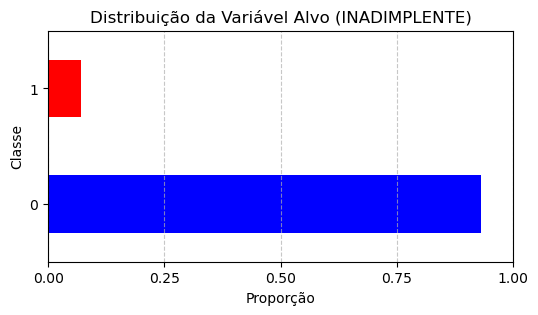

In [14]:
print(base_dev['INADIMPLENTE'].value_counts(normalize=True))
# Contagem percentual
dist = base_dev['INADIMPLENTE'].value_counts(normalize=True)

# Gráfico de barras horizontal
plt.figure(figsize=(6, 3))
dist.plot(kind='barh', color=['blue', 'red'])
plt.title('Distribuição da Variável Alvo (INADIMPLENTE)')
plt.xlabel('Proporção')
plt.ylabel('Classe')
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Com a base final devidamente tratada, seguimos agora para a análise exploratória, buscando entender padrões, relações entre variáveis e possíveis sinais de inadimplência.

## 2- Análise Exploratória

Antes de tudo, vamos olhar algumas estatísticas básicas dos dados.

In [15]:
base_dev.describe(include='all').T  # Para ver estatísticas de todas as colunas

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
ID_CLIENTE,77413.0,NaN,NaN,NaN,4662288801698715648.0,8784237149961904.0,2369364892942408192.0,4817816966382229504.0,6969348581033924608.0,9206030810342980608.0,2665731568533809664.0
SAFRA_REF,77413,NaN,NaN,NaN,2020-01-19 03:59:24.099053056,2018-08-01 00:00:00,2019-05-01 00:00:00,2020-01-01 00:00:00,2020-10-01 00:00:00,2021-06-01 00:00:00,NaN
DATA_EMISSAO_DOCUMENTO,77413,NaN,NaN,NaN,2020-02-02 21:03:20.477956096,2018-08-17 00:00:00,2019-05-21 00:00:00,2020-01-27 00:00:00,2020-10-27 00:00:00,2021-06-30 00:00:00,NaN
DATA_PAGAMENTO,77413,NaN,NaN,NaN,2020-02-26 00:38:12.452172288,2018-06-19 00:00:00,2019-06-13 00:00:00,2020-02-19 00:00:00,2020-11-18 00:00:00,2021-11-24 00:00:00,NaN
DATA_VENCIMENTO,77413,NaN,NaN,NaN,2020-02-26 04:45:04.103961600,2017-11-27 00:00:00,2019-06-13 00:00:00,2020-02-18 00:00:00,2020-11-18 00:00:00,2027-03-31 00:00:00,NaN
VALOR_A_PAGAR,77413.0,NaN,NaN,NaN,46543.388422,0.0,18838.08,34762.78,60818.04,4400000.0,46229.710147
TAXA,77413.0,NaN,NaN,NaN,6.78962,4.99,5.99,5.99,6.99,11.99,1.798237
VALOR_A_PAGAR_NULO,77413.0,NaN,NaN,NaN,0.015101,0.0,0.0,0.0,0.0,1.0,0.121955
INADIMPLENTE,77413.0,NaN,NaN,NaN,0.070221,0.0,0.0,0.0,0.0,1.0,0.25552
DATA_CADASTRO,77413,NaN,NaN,NaN,2010-04-07 09:11:51.089868544,2000-08-15 00:00:00,2005-05-05 00:00:00,2011-02-14 00:00:00,2014-11-26 00:00:00,2021-06-23 00:00:00,NaN


Com base nas estatísticas obtidas da base final, podemos destacar os seguintes pontos relevantes:

- A variável alvo `INADIMPLENTE` está fortemente desbalanceada, com aproximadamente **7% de inadimplência**. Isso exigirá atenção especial durante a modelagem, como uso de técnicas de reamostragem, ajuste de pesos ou métricas apropriadas.
  
- A coluna `VALOR_A_PAGAR` apresenta **valores extremos (outliers)**, com um máximo de 4,4 milhões e desvio padrão elevado. Isso pode influenciar negativamente alguns algoritmos e será avaliado com visualizações e, se necessário, com transformações como `log`.

- A variável `TAXA` possui **baixa variabilidade**, concentrando-se entre 5% e 7%. Isso pode limitar sua capacidade de discriminar inadimplência, mas será avaliada na análise bivariada.

- A variável `FLAG_PF` indica que a **quase totalidade dos clientes são PJ** (~99,7%). Embora seja válida, provavelmente terá pouco impacto na previsão.

- As colunas `RENDA_MES_ANTERIOR` e `NO_FUNCIONARIOS` apresentam distribuições assimétricas, com **valores máximos elevados** e desvio padrão alto, especialmente no caso da renda. Assim como `VALOR_A_PAGAR`, essas variáveis podem exigir transformações.

- As flags `_NULO` criadas para indicar valores ausentes estão coerentes e poderão ser avaliadas como **indicadores de risco**.

- Variáveis categóricas como `SEGMENTO_INDUSTRIAL`, `DOMINIO_EMAIL`, `PORTE`, `DDD` e `CEP_2_DIG` possuem distribuições concentradas em poucos valores (ex: "Serviços", "Médio", "YAHOO") e devem ser analisadas com relação à taxa de inadimplência por categoria. Algumas colunas com alta cardinalidade, como `CEP_2_DIG`, podem requerer agrupamento.

A partir das conclusões acima, os próximos passos da análise exploratória serão:

1. **Análise univariada segmentada por inadimplência**, para entender como cada variável se comporta entre os grupos `inadimplente = 0` e `inadimplente = 1`.

2. **Visualização de distribuições e outliers** para variáveis numéricas relevantes, com atenção especial para `VALOR_A_PAGAR`, `RENDA_MES_ANTERIOR` e `NO_FUNCIONARIOS`.

3. **Análise da taxa de inadimplência por categoria**, identificando grupos com maior risco e possíveis padrões regionais (ex: `DDD` e `CEP_2_DIG`).

4. **Verificação do impacto das flags de ausência (_NULO)** sobre a inadimplência — ausências podem carregar significado estatístico.

5. **Análise temporal da inadimplência**, utilizando a variável `SAFRA_REF` para verificar possíveis padrões ao longo do tempo.

Essas etapas vão ajudar a entender a dinâmica da base e identificar variáveis mais relevantes para a construção do modelo preditivo.


### 2.1 - Análise Univariada Segmentada por Inadimplência

Para facilitar a análise visual e mitigar o impacto de valores extremos (outliers), as variáveis numéricas serão transformadas utilizando o logaritmo natural durante a etapa de visualização. Essa transformação permite uma melhor comparação entre os grupos de clientes inadimplentes e adimplentes, evidenciando padrões mais claros de distribuição.

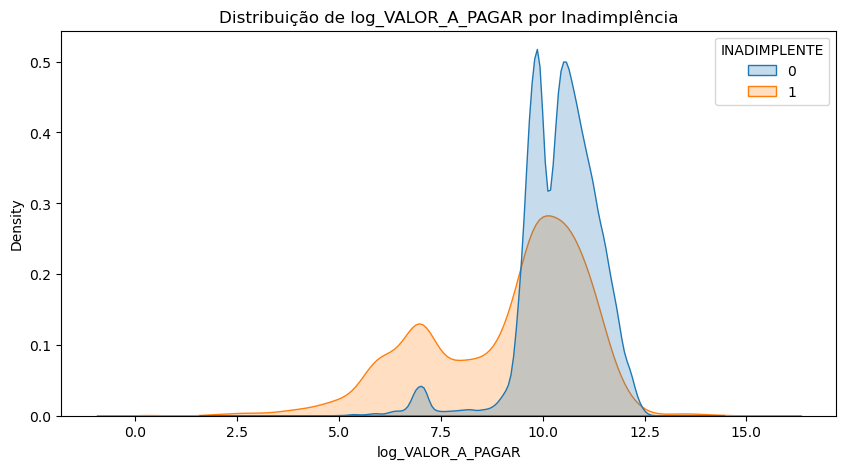

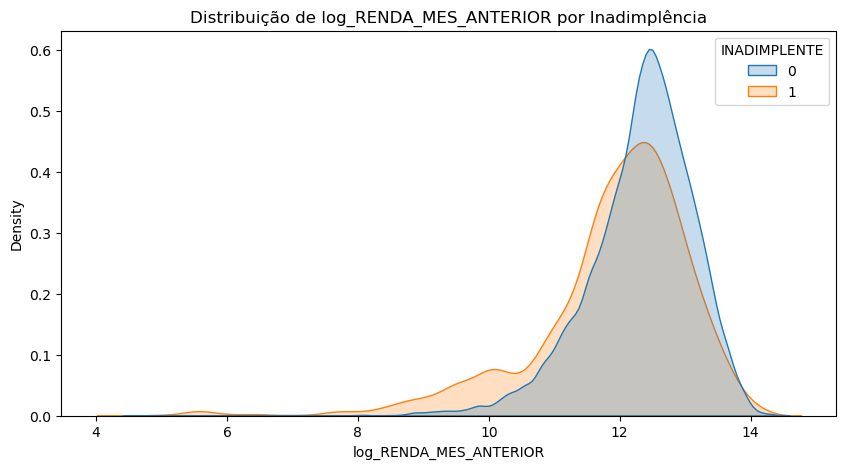

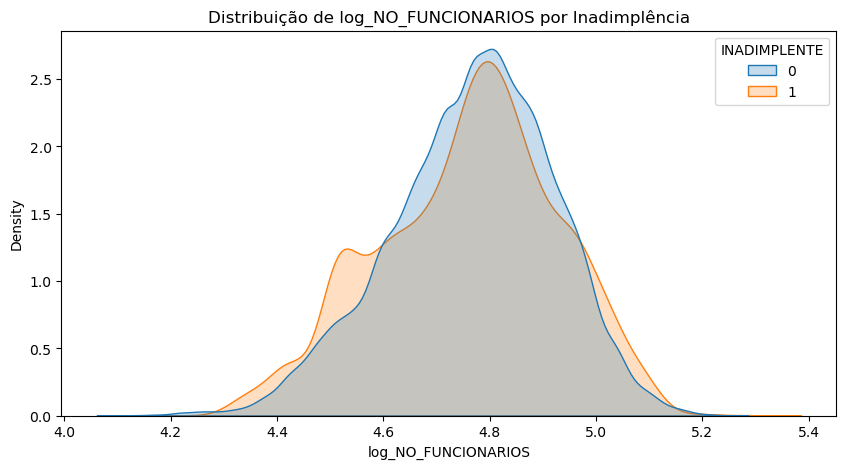

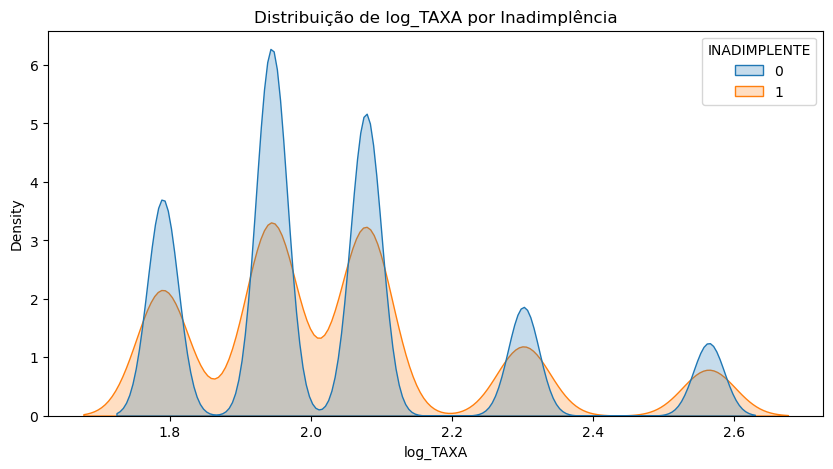

In [16]:
def plot_kde(df, col, log=False):
    """
    Gera um gráfico de Densidade de Kernel (KDE) para uma coluna específica de um DataFrame,
    separando as distribuições pela coluna 'INADIMPLENTE'.

    Parâmetros:
        df (pd.DataFrame): O DataFrame contendo os dados.
        col (str): O nome da coluna numérica a ser plotada.
        log (bool, opcional): Se True, aplica uma transformação logarítmica (log1p)
                             na coluna especificada antes de plotar..

    Retorna:
        None: Exibe o gráfico KDE diretamente.
    """

    plt.figure(figsize=(10, 5))
    # Aplica a transformação logarítmica, se especificado
    if log:
        df = df[df[col] > 0].copy()
        df[f'log_{col}'] = np.log1p(df[col])
        col = f'log_{col}'
    
    # Gera o gráfico
    sns.kdeplot(data=df, x=col, hue='INADIMPLENTE', fill=True, common_norm=False)
    plt.title(f'Distribuição de {col} por Inadimplência')
    plt.show()

cols_num = ['VALOR_A_PAGAR', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'TAXA']
for col in cols_num:
    plot_kde(base_dev, col, log=True)

Observando os gráficos, podemos perceber que:

- Cobranças de menor valor parecem estar associadas a uma maior propensão à inadimplência. Isso pode indicar que clientes com menor comprometimento financeiro tendem a priorizar menos esses pagamentos, ou que tais cobranças representam operações de menor valor e, possivelmente, com menor controle ou acompanhamento;

- A análise da variável log_RENDA_MES_ANTERIOR sugere que níveis mais baixos de renda estão associados a uma maior proporção de inadimplência. Esse comportamento é coerente com a expectativa de que empresas ou indivíduos com menor faturamento mensal enfrentem mais dificuldades para manter os pagamentos em dia;

- Empresas com menor número de funcionários apresentam uma leve tendência a maior inadimplência. Embora a diferença entre os grupos seja menos acentuada do que em outras variáveis analisadas, essa característica ainda pode contribuir para a modelagem preditiva quando combinada com outras informações;

- Os clientes se distribuem em diferentes faixas de taxa (log_TAXA), com múltiplos picos de concentração. No entanto, ao compararmos os inadimplentes com os adimplentes, nota-se que há uma maior densidade relativa de inadimplentes em faixas de taxa mais elevadas. Isso sugere que valores mais altos de taxa estão potencialmente associados a um maior risco de inadimplência, o que reforça a relevância da variável log_TAXA na determinação de uma possível inadimplência;

Dado o comportamento observado nas distribuições e a presença de assimetrias nas variáveis originais, optaremos por utilizar as versões log-transformadas também na modelagem preditiva, a fim de melhorar a performance dos algoritmos e a estabilidade das variáveis.

Quanto aos outliers, vamos agora observar o comportamento das variáveis numéricas por meio de boxplots, analisando a distribuição dos dados brutos e a presença de valores extremos.

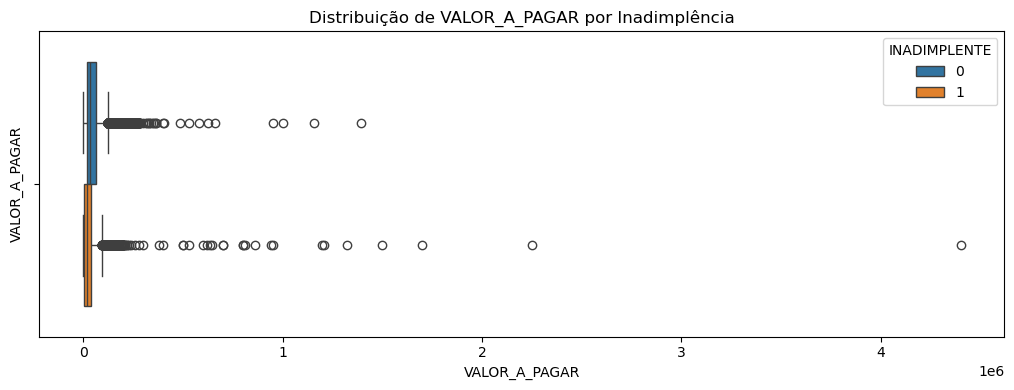

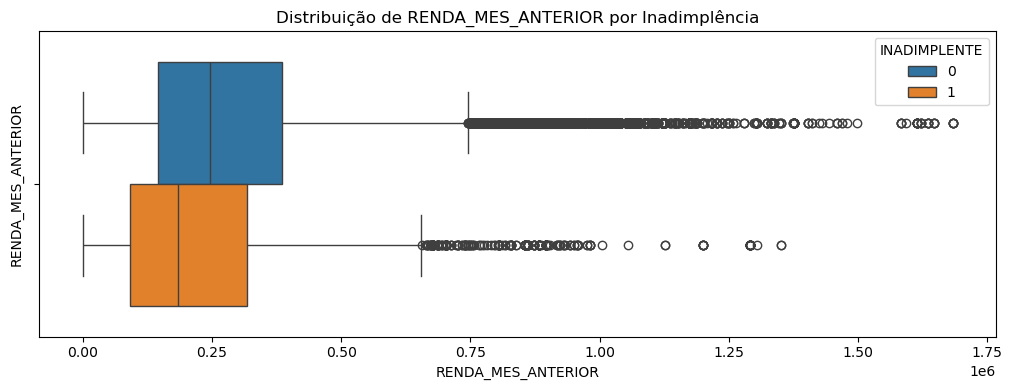

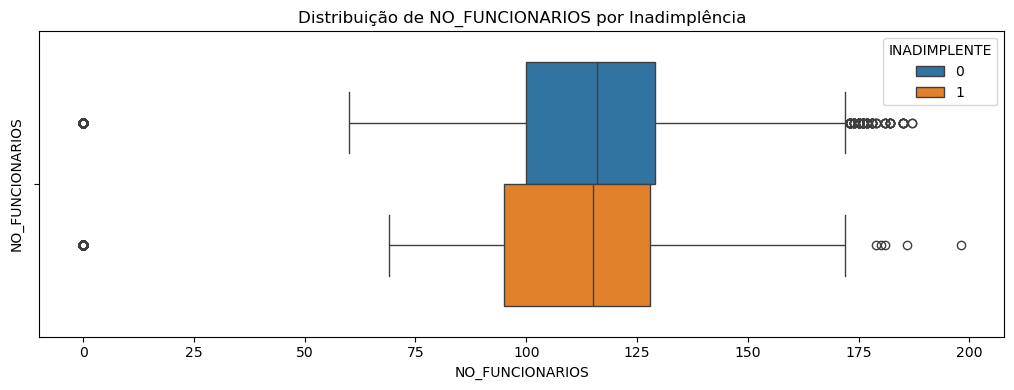

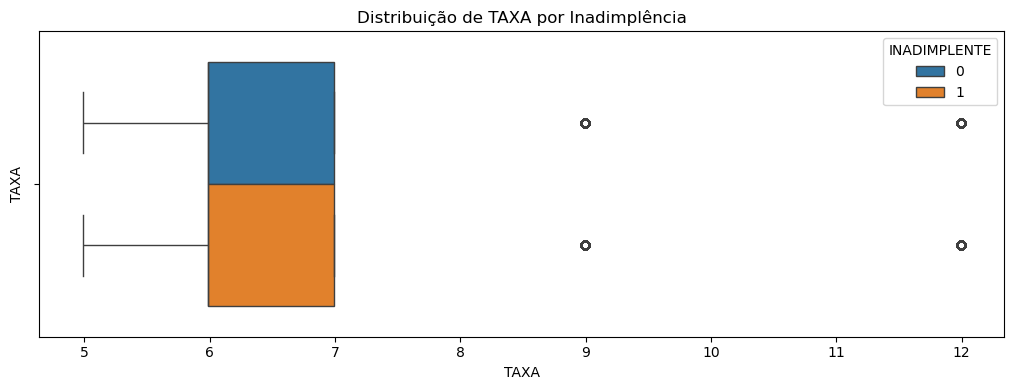

In [17]:
def plot_boxplot(df, col):
    """
    Gera um gráfico de caixa (Box Plot) para uma coluna numérica específica de um DataFrame,
    separando as distribuições pela coluna 'INADIMPLENTE'.

    Parâmetros:
        df (pd.DataFrame): O DataFrame contendo os dados.
        col (str): O nome da coluna numérica a ser plotada.

    Retorna:
        None: Exibe o gráfico de caixa diretamente.
    """

    # geração do gráfico
    plt.figure(figsize=(10, 4))
    sns.boxplot(df, x=col, hue='INADIMPLENTE')
    plt.title(f'Distribuição de {col} por Inadimplência')
    plt.tight_layout()
    plt.ylabel(f'{col}')
    plt.show()

for col in ['VALOR_A_PAGAR', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'TAXA']:
    plot_boxplot(base_dev, col)

De forma geral, as distribuições originais das variáveis numéricas analisadas apresentam forte assimetria positiva, com presença de valores extremos que dificultam a diferenciação clara entre inadimplentes e adimplentes nas representações brutas. No entanto, as versões log-transformadas dessas variáveis mostraram melhor desempenho na separação dos grupos, além de maior estabilidade estatística. Esse comportamento reforça a decisão de adotar as transformações logarítmicas na modelagem preditiva, garantindo maior robustez e interpretabilidade dos resultados.

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\1738844545.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby(col)['INADIMPLENTE'].mean().sort_values(ascending=False)


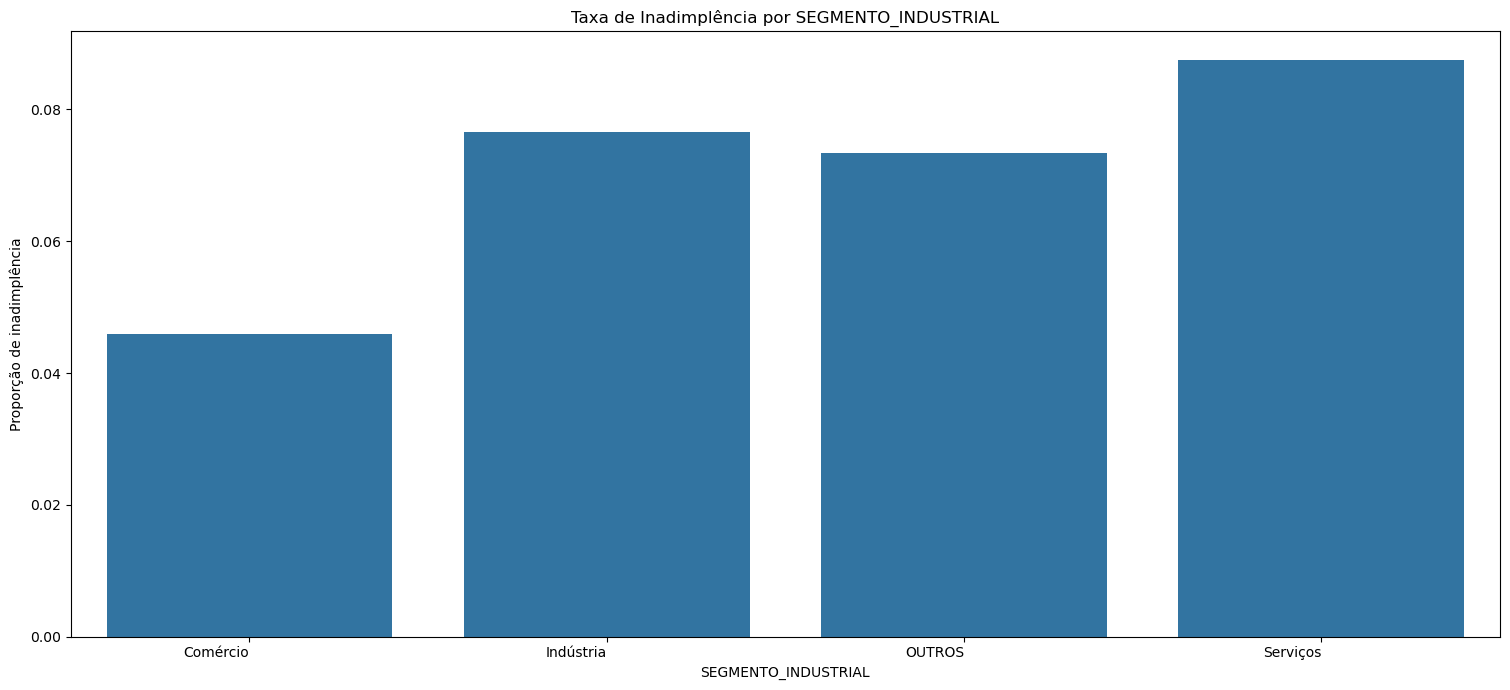

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\1738844545.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby(col)['INADIMPLENTE'].mean().sort_values(ascending=False)


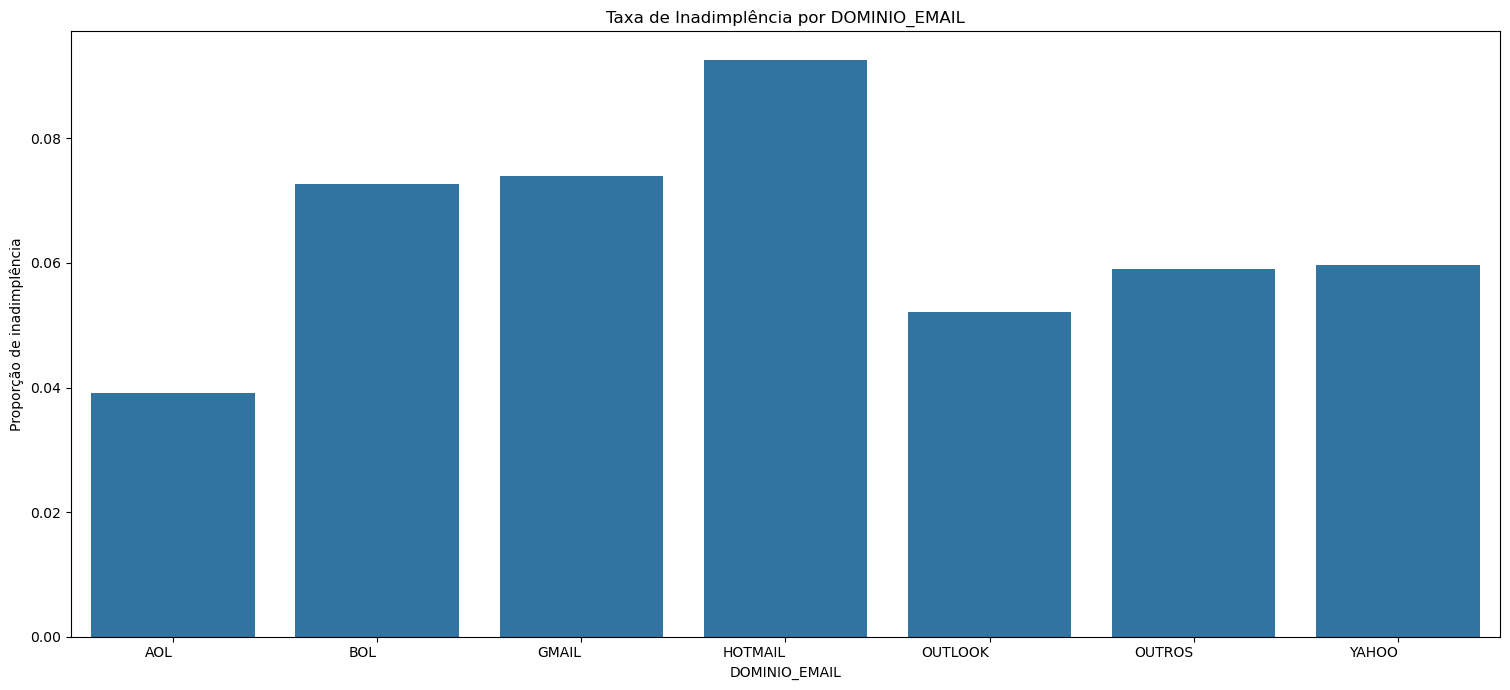

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\1738844545.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby(col)['INADIMPLENTE'].mean().sort_values(ascending=False)


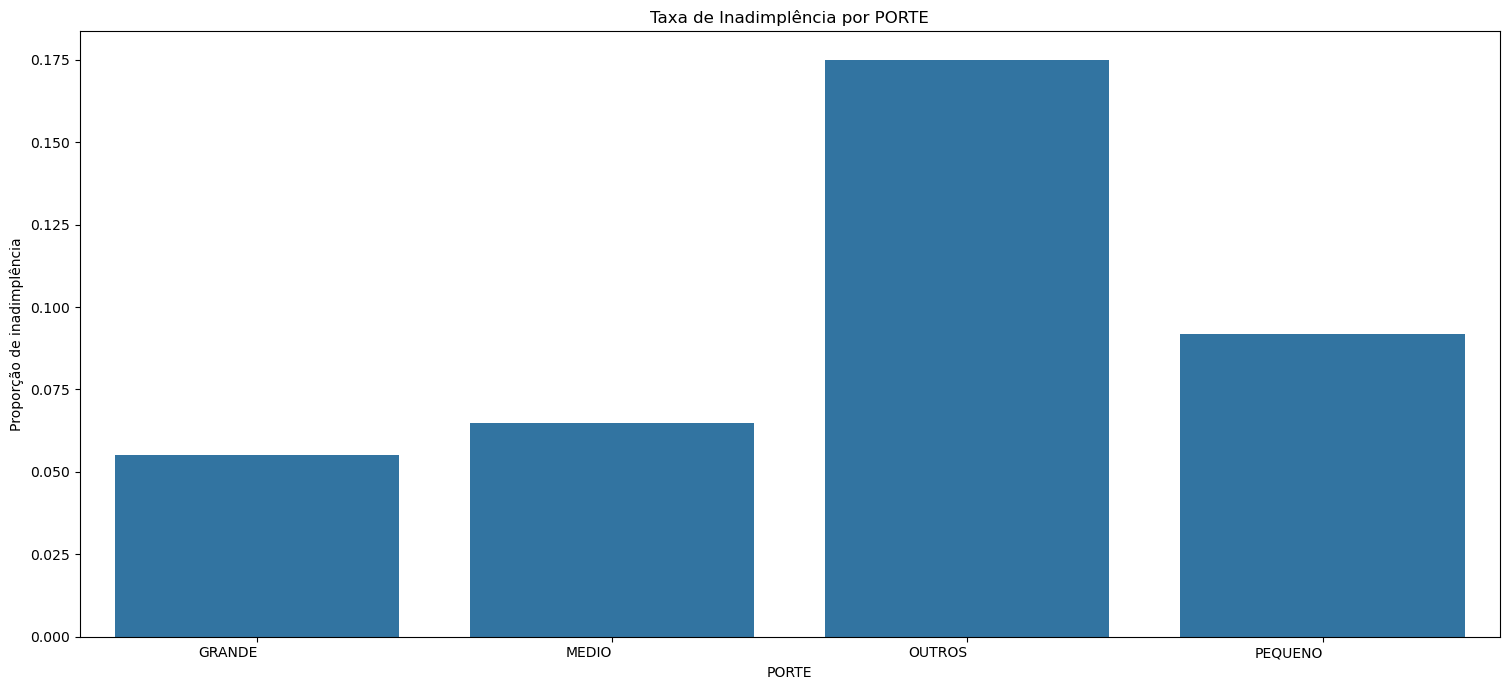

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\1738844545.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby(col)['INADIMPLENTE'].mean().sort_values(ascending=False)


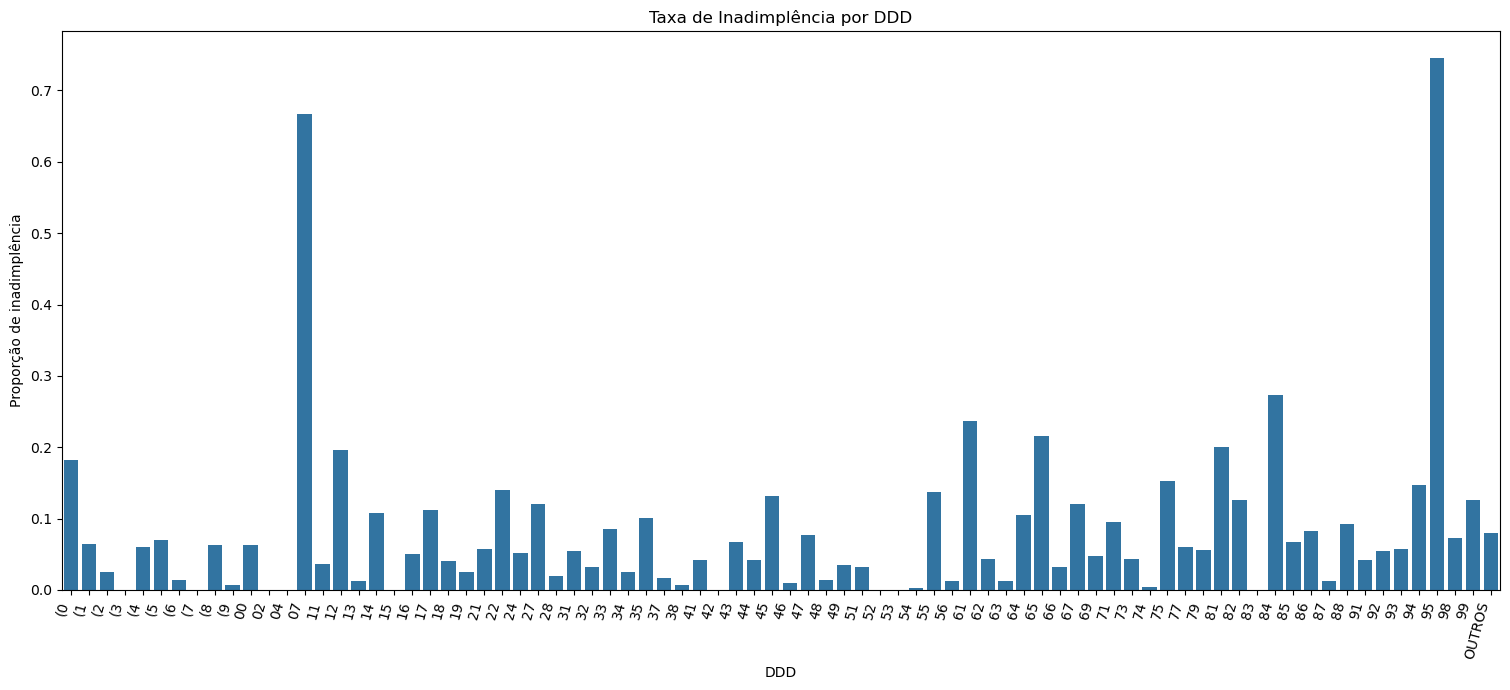

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\1738844545.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby(col)['INADIMPLENTE'].mean().sort_values(ascending=False)


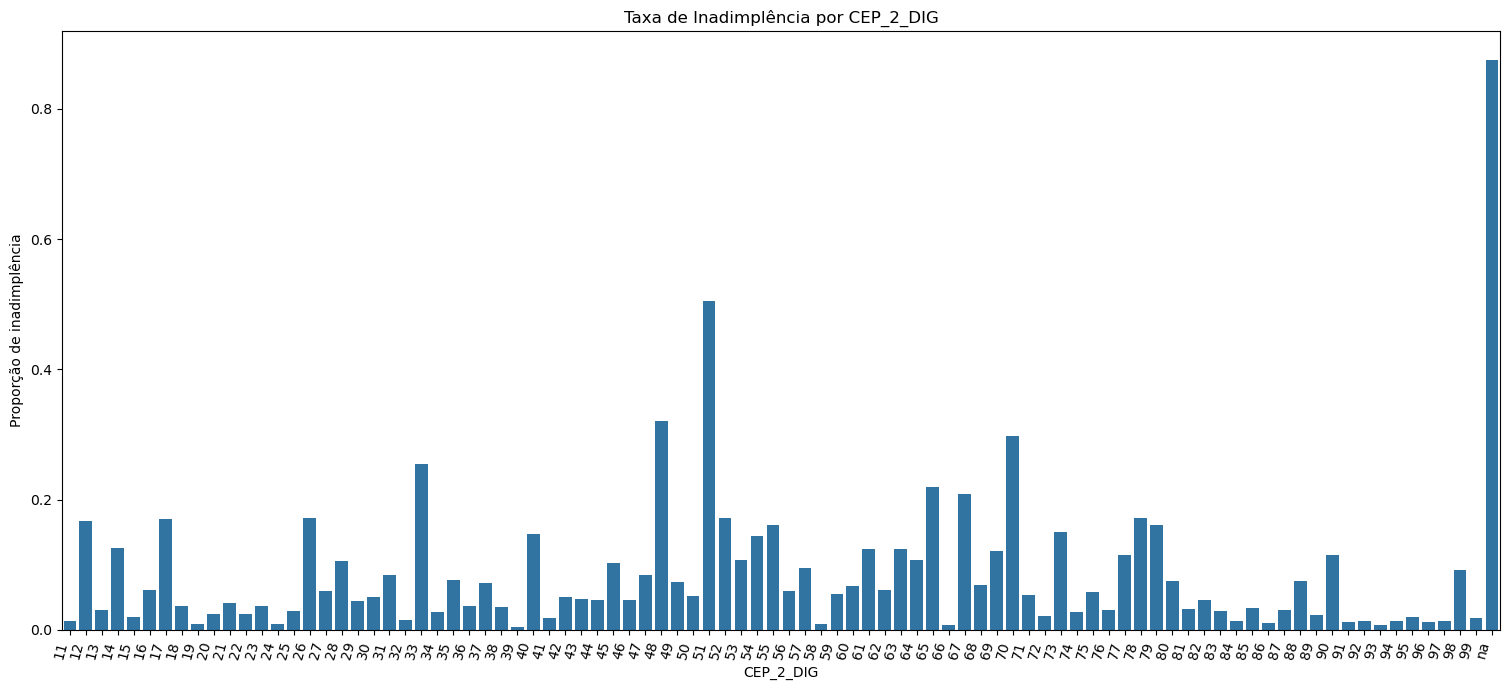

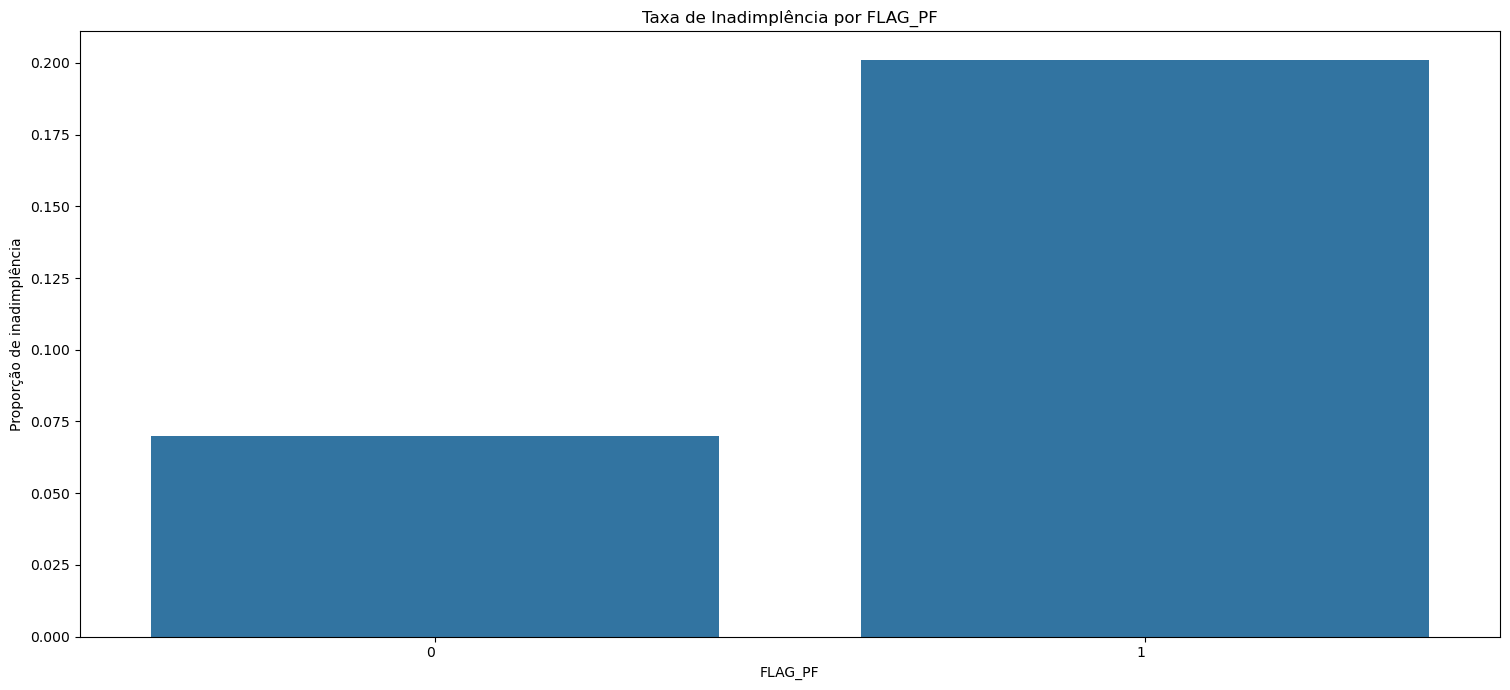

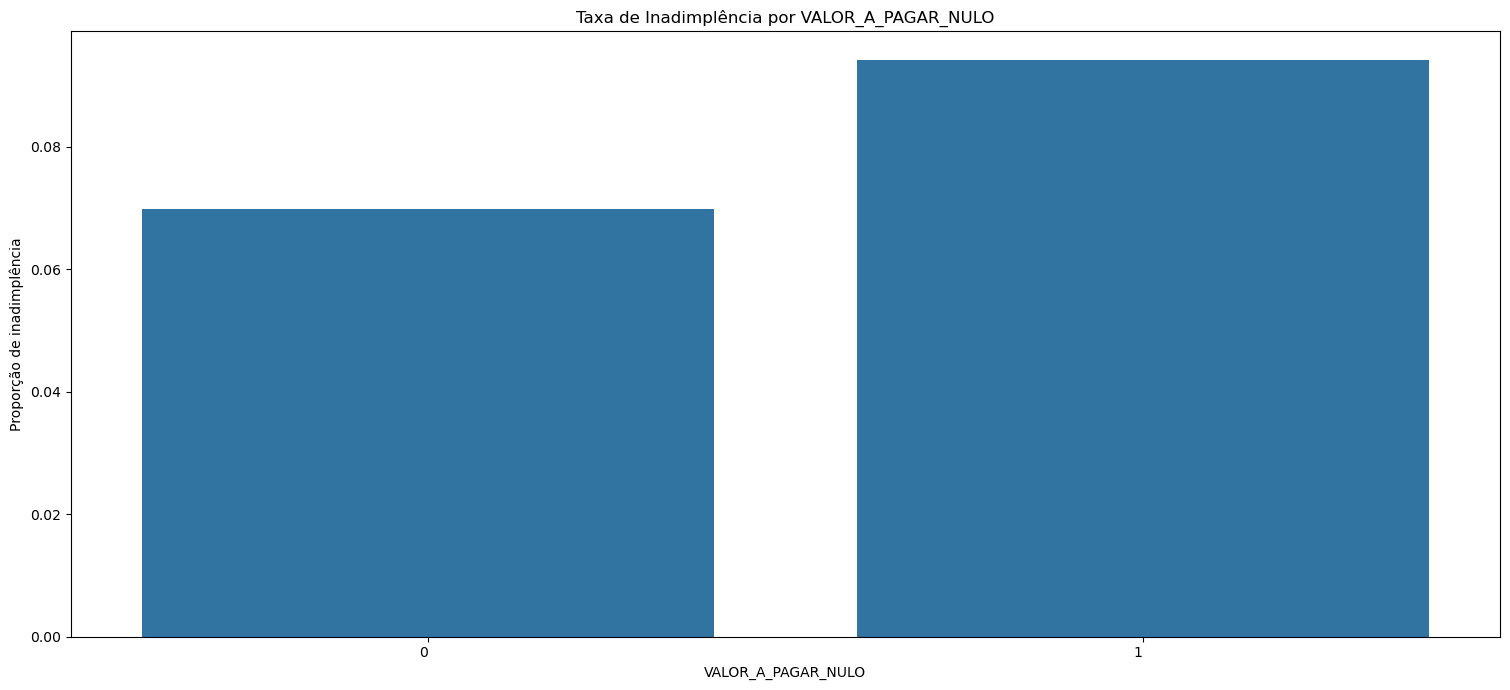

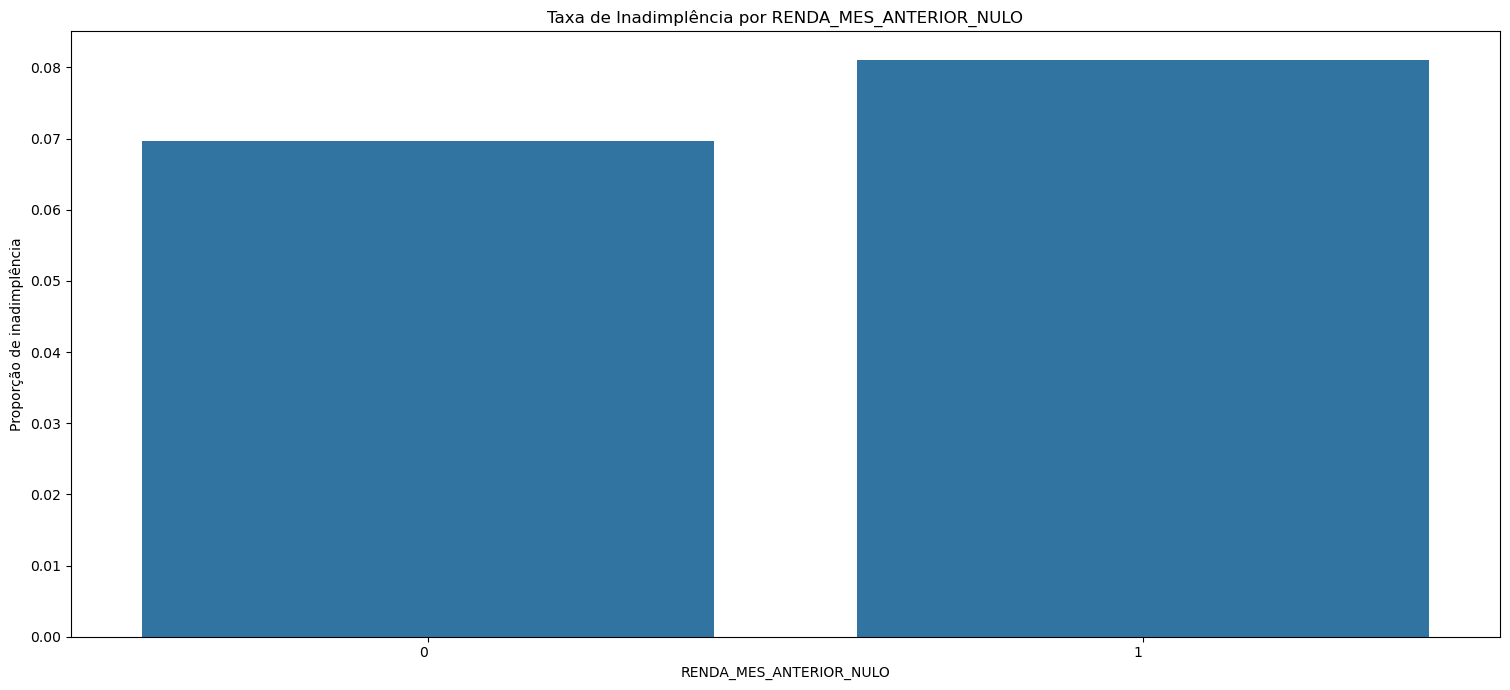

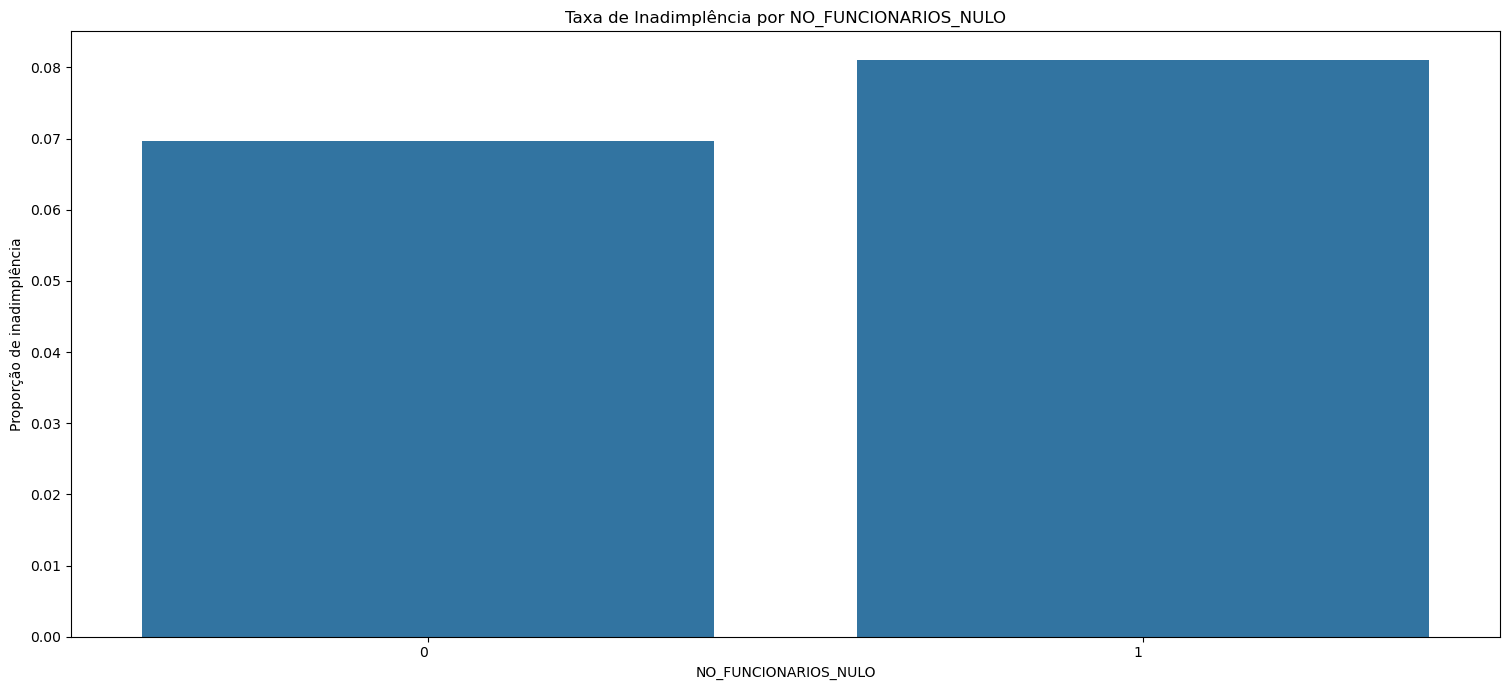

In [18]:
def plot_bar_categorical(df, col, rotation=0):
    """
    Gera um gráfico de barras mostrando a taxa de inadimplência para cada categoria
    em uma coluna categórica de um DataFrame.

    Parâmetros:
        df (pd.DataFrame): O DataFrame contendo os dados.
        col (str): O nome da coluna categórica a ser plotada.
        rotation (int, opcional): Rotação dos rótulos do eixo x em graus.
                                   Defaults to 0.

    Retorna:
        None: Exibe o gráfico de barras diretamente.
    """

    # Calcula a taxa de inadimplência para cada categoria na coluna especificada
    # Agrupa o DataFrame pela coluna 'col' e calcula a média de 'INADIMPLENTE'
    # Ordena os resultados em ordem decrescente da taxa de inadimplência
    temp = df.groupby(col)['INADIMPLENTE'].mean().sort_values(ascending=False)

    # gera o gráfico
    plt.figure(figsize=(15, 7))
    sns.barplot(x=temp.index, y=temp.values)
    plt.title(f'Taxa de Inadimplência por {col}')
    plt.xticks(rotation=rotation, ha='right')
    plt.tight_layout()
    plt.ylabel('Proporção de inadimplência')
    plt.show()

cols_cat = ['SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'PORTE', 'DDD', 'CEP_2_DIG', 'FLAG_PF', 'VALOR_A_PAGAR_NULO', 'RENDA_MES_ANTERIOR_NULO', 'NO_FUNCIONARIOS_NULO']
for col in cols_cat:
    if col in ['DDD', 'CEP_2_DIG']:
        plot_bar_categorical(base_dev, col, rotation=75)
    else:
        plot_bar_categorical(base_dev, col)

Observando os gráficos acima podemos notar que:

- O setor de **Serviços** apresenta a maior taxa de inadimplência, seguido pelos setores de **Indústria** e **Outros**. Já o **Comércio** se destaca por ter a menor taxa de inadimplência entre os segmentos analisados;

- Domínios como **Hotmail** e **Gmail** apresentam taxas de inadimplência acima da média. Esses padrões podem refletir perfis específicos de clientes — como idade, familiaridade digital ou canal de aquisição — e, por isso, devem ser considerados com cautela, pois podem atuar como proxies indiretos de comportamento de risco;

- Empresas de **grande e médio porte** apresentam as menores taxas de inadimplência, enquanto aquelas classificadas como **pequeno porte** ou **outros** concentram os maiores índices. Isso sugere uma possível associação entre o porte da empresa e o risco de crédito, indicando que empresas menores ou mal categorizadas podem representar maior propensão à inadimplência. A elevada taxa no grupo **OUTROS** pode refletir falhas de categorização, registros incompletos ou perfis atípicos de clientes, merecendo atenção especial em processos de segmentação e análise de risco;

- Embora alguns **DDDs** e **CEPs** apresentem taxas de inadimplência extremamente altas, é importante considerar que esses picos podem ser reflexo de grupos com baixa representatividade. Isso reduz a confiabilidade estatística dessas proporções e reforça a importância de analisar os dados em conjunto com o volume de observações por grupo;

- A taxa de inadimplência entre **pessoas físicas (PF)** é significativamente maior do que entre **pessoas jurídicas (PJ)**. Esse resultado sugere que clientes do tipo PF estão associados a um risco de crédito mais elevado, sendo um fator relevante a ser considerado;

- Embora a diferença nas taxas de inadimplência entre registros com e sem dados ausentes não seja tão expressiva, observa-se um padrão consistente: a ausência de informações relevantes — como **valor a pagar, renda do mês anterior** e **número de funcionários** — está associada a uma inadimplência ligeiramente maior. Esse comportamento sugere que a falta desses dados pode não ser aleatória e pode estar correlacionada a perfis de maior risco, o que levanta um alerta importante quanto à qualidade e completude das informações utilizadas na análise;

Diante disso, para os dados de **CEP** e **DDD**, é pertinente aprofundar a análise a fim de entender melhor sua relação com a inadimplência e verificar as proporções de cada grupo, buscando identificar uma possível regionalização do risco de crédito.

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\2646306666.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = base_dev.groupby(col).agg(


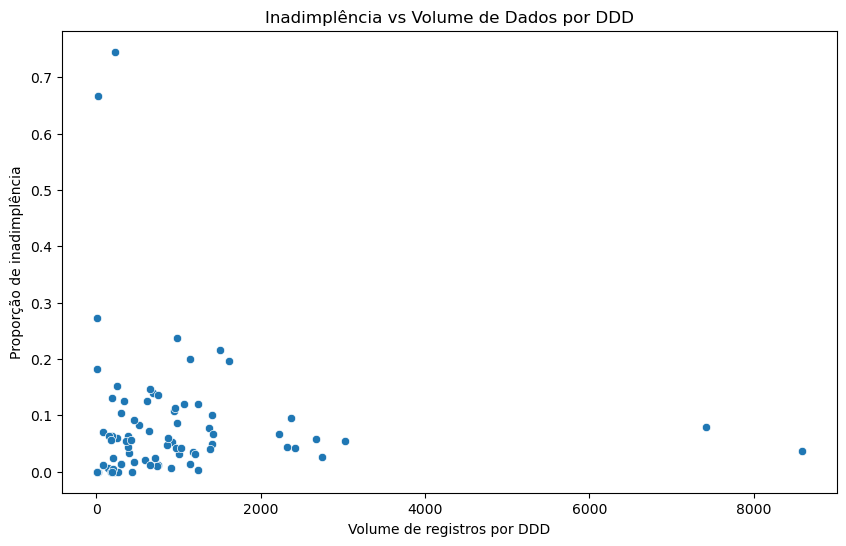

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\2646306666.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = base_dev.groupby(col).agg(


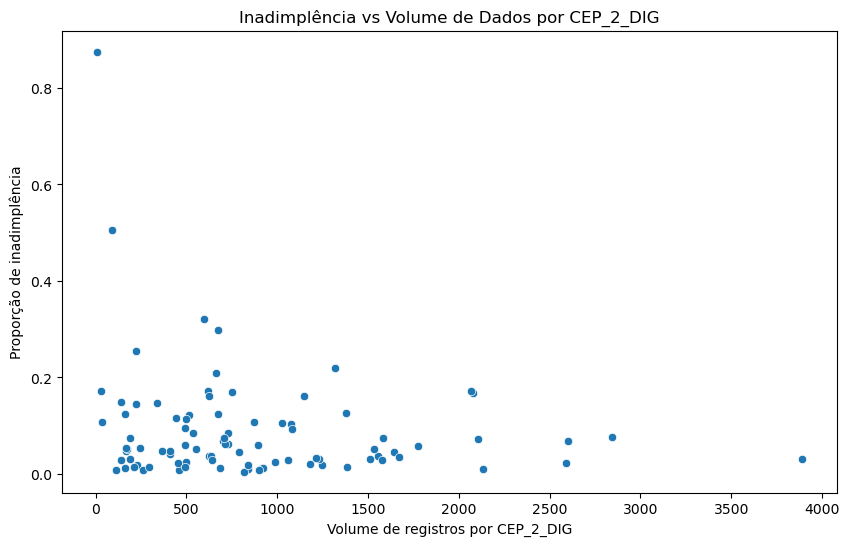

In [19]:
# visualização da proporção de inadimplência pelo volume de dados para variável DDD

def plot_volume_por_inadimplencia(df, col):

    """
    Gera um gráfico de dispersão (Scatter Plot) mostrando a relação entre o volume
    de registros e a proporção de inadimplência para cada categoria em uma coluna específica.

    Parâmetros:
        df (pd.DataFrame): O DataFrame contendo os dados.
        var (str): O nome da coluna categórica a ser usada para agrupar os dados.

    Retorna:
        None: Exibe o gráfico de dispersão diretamente.
    """
    stats = base_dev.groupby(col).agg(
    inadimplencia=('INADIMPLENTE', 'mean'),
    volume=('INADIMPLENTE', 'count')
).reset_index()

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=stats, x='volume', y='inadimplencia')
    plt.title(f"Inadimplência vs Volume de Dados por {col}")
    plt.xlabel(f"Volume de registros por {col}")
    plt.ylabel("Proporção de inadimplência")
    plt.show()

for col in ['DDD', 'CEP_2_DIG']:
    plot_volume_por_inadimplencia(base_dev, col)

A análise de dispersão entre a inadimplência e o volume de registros por DDD e por os dois primeiros dígitos do CEP reforça a hipótese de que muitas das taxas elevadas observadas em determinados grupos são influenciadas por baixa representatividade amostral. Em ambos os gráficos, é possível observar uma concentração de pontos com alta inadimplência nos extremos de menor volume, indicando que esses valores podem ser estatisticamente instáveis. Isso evidencia a importância de ponderar as análises por volume de dados, evitando conclusões precipitadas com base em proporções distorcidas por pequenos grupos.

Após a análise das variáveis numéricas e a confirmação da importância das transformações para lidar com assimetrias e outliers, é importante agora investigar como o comportamento da inadimplência evolui ao longo do tempo.

Para isso, utilizaremos a variável `SAFRA_REF` — que representa a referência temporal dos contratos — a fim de identificar **padrões sazonais, tendências ou variações pontuais na taxa de inadimplência**. Essa análise pode revelar períodos críticos e apoiar estratégias preditivas mais sensíveis à dimensão temporal.

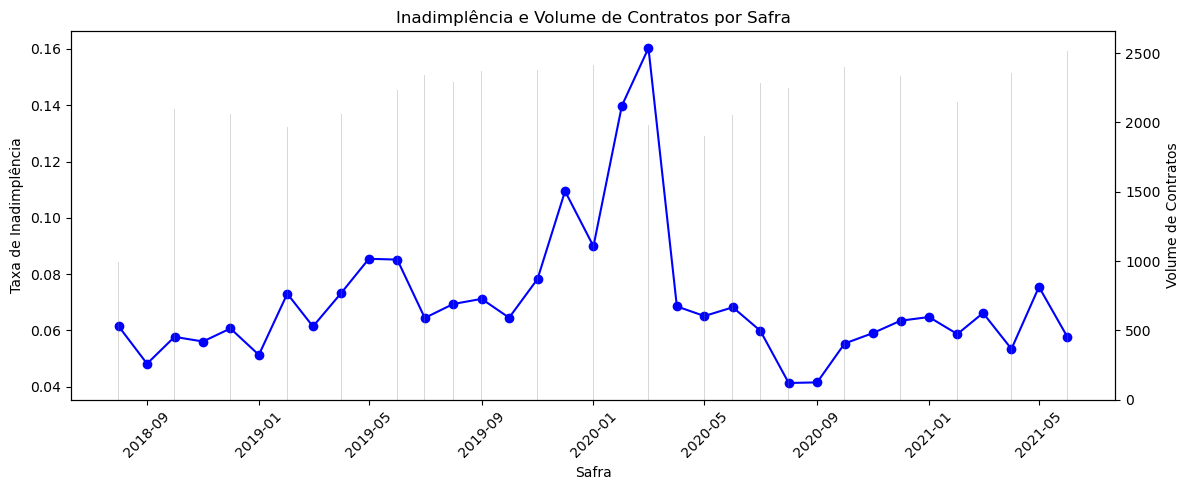

In [20]:
# calulando taxa e volume de inadimplência por período
inad_count = base_dev.groupby('SAFRA_REF').agg(
    inadimplencia=('INADIMPLENTE', 'mean'),
    volume=('INADIMPLENTE', 'count')
).reset_index()

# gerando gráfico para visualizar a taxa de inadimplência ao longo do tempo
fig, ax1 = plt.subplots(figsize=(12,5))

ax2 = ax1.twinx()
ax1.plot(inad_count['SAFRA_REF'], inad_count['inadimplencia'], color='blue', marker='o', label='Inadimplência')
ax2.bar(inad_count['SAFRA_REF'], inad_count['volume'], color='gray', alpha=0.3, label='Volume')

ax1.set_ylabel('Taxa de Inadimplência')
ax2.set_ylabel('Volume de Contratos')
ax1.set_xlabel('Safra')
ax1.set_title('Inadimplência e Volume de Contratos por Safra')
ax1.tick_params(axis='x', rotation=45)
fig.tight_layout()
plt.show()

A análise da inadimplência ao longo do tempo revela uma **tendência geral de estabilidade** na taxa de inadimplência entre 2018 e 2021. A maioria das safras apresenta taxas entre 5% e 8%, com **flutuações relativamente discretas**.

Entretanto, observamos um **pico acentuado no início de 2020**, atingindo uma inadimplência superior a 16%. Esse comportamento coincide com o início da pandemia de COVID-19 no Brasil, indicando um possível **impacto externo abrupto** sobre a capacidade de pagamento dos clientes. Após esse período, nota-se uma **rápida queda e posterior retorno à normalidade** nas taxas de inadimplência.

Do ponto de vista analítico, esse comportamento reforça:

- A **importância de considerar o fator temporal** na modelagem, principalmente para identificar períodos atípicos.

- A necessidade de atenção a **eventuais efeitos sazonais ou externos**, como crises econômicas ou mudanças regulatórias.

Além da data de referência da cobrança (`SAFRA_REF`), o dataset também apresenta as datas de vencimento de cada título. Avaliar a diferença entre a safra e o vencimento pode fornecer indícios importantes sobre o prazo concedido para pagamento, o que pode impactar diretamente o risco de inadimplência.

A variável `DEFASAGEM_SAFRA_VENCIMENTO`, calculada como o número de meses entre a data de referência da cobrança e o vencimento da fatura, foi criada para investigar essa relação.

A seguir, analisamos a distribuição dessa defasagem e a taxa de inadimplência média por faixa de prazo.

In [21]:
# cálculo da defasagem entre 
def diff_meses(data1, data2):
    """
    Calcula a diferença em meses entre duas datas.

    Parâmetros:
        data1 (datetime.date): A data inicial.
        data2 (datetime.date): A data final.

    Retorna:
        int: A diferença em meses entre data2 e data1.
             Um valor positivo se data2 for posterior a data1.
             Um valor negativo se data2 for anterior a data1.
             Zero se as datas forem iguais.
    """
    return (data2.year - data1.year) * 12 + data2.month - data1.month

base_dev['DEFASAGEM_SAFRA_VENCIMENTO'] = base_dev.apply(lambda x: diff_meses(x['SAFRA_REF'], x['DATA_VENCIMENTO']), axis=1)

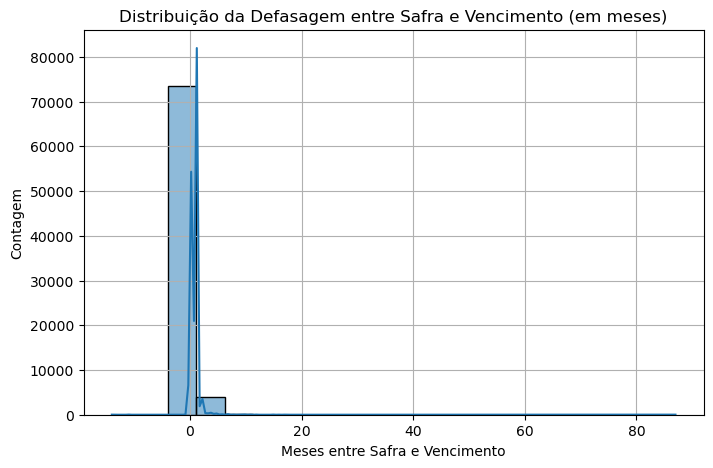

In [22]:
# visualização da distribuição da diferença entre SAFRA e vencimento
plt.figure(figsize=(8,5))
sns.histplot(base_dev['DEFASAGEM_SAFRA_VENCIMENTO'], bins=20, kde=True)
plt.title('Distribuição da Defasagem entre Safra e Vencimento (em meses)')
plt.xlabel('Meses entre Safra e Vencimento')
plt.ylabel('Contagem')
plt.grid(True)
plt.show()

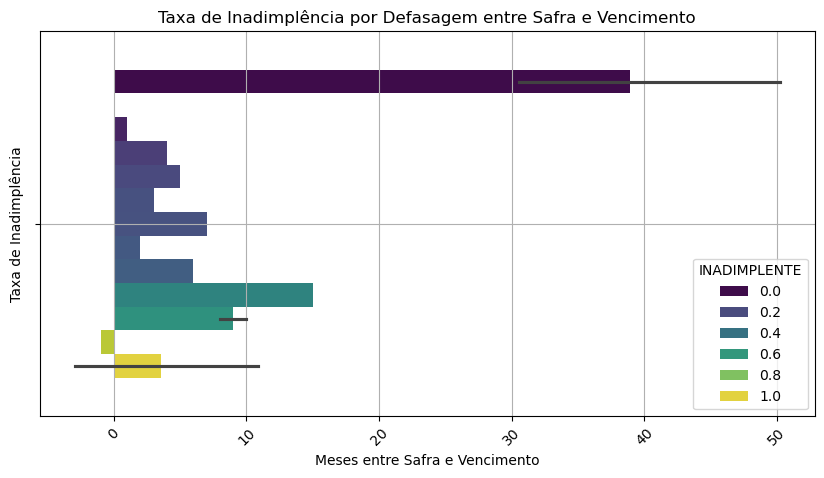

In [23]:
# visualização da taxa de inadimplência conforme aumenta o prazo de vencimento
inad_per_defasagem = base_dev.groupby('DEFASAGEM_SAFRA_VENCIMENTO')['INADIMPLENTE'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=inad_per_defasagem, x='DEFASAGEM_SAFRA_VENCIMENTO', hue='INADIMPLENTE', palette='viridis')
plt.title('Taxa de Inadimplência por Defasagem entre Safra e Vencimento')
plt.xlabel('Meses entre Safra e Vencimento')
plt.ylabel('Taxa de Inadimplência')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

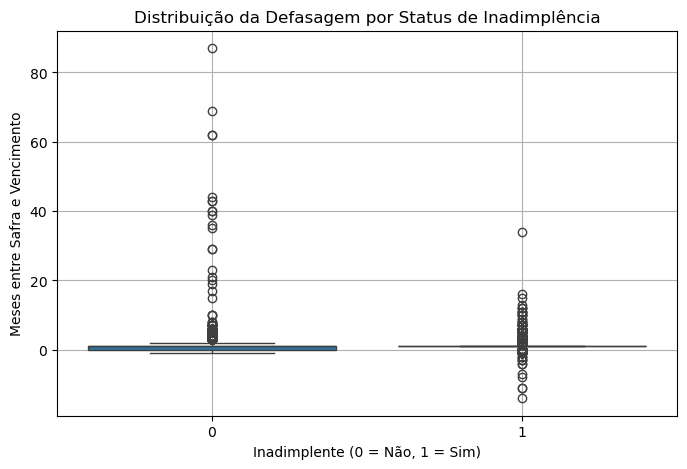

In [24]:
# Visualização da defasagem por inadimplência

plt.figure(figsize=(8,5))
sns.boxplot(data=base_dev, x='INADIMPLENTE', y='DEFASAGEM_SAFRA_VENCIMENTO')
plt.title('Distribuição da Defasagem por Status de Inadimplência')
plt.xlabel('Inadimplente (0 = Não, 1 = Sim)')
plt.ylabel('Meses entre Safra e Vencimento')
plt.grid(True)
plt.show()

Observando o comportamento dos dados, podemos observar que:

- A defasagem entre a data de referência da cobrança (SAFRA_REF) e a data de vencimento apresenta forte concentração entre 0 e 6 meses, com poucos casos extremos (outliers) de vencimento muito postergado. Isso sugere que a maior parte das cobranças é gerada com vencimentos próximos à sua referência, com alguns casos fora do padrão que podem demandar atenção;

- Há um aparente aumento na taxa de inadimplência à medida que a defasagem entre safra e vencimento aumenta, especialmente a partir de 5 meses. Esse comportamento pode refletir maior risco associado a cobranças com vencimentos mais distantes da safra, sendo uma variável importante para o modelo de previsão;

- O boxplot reforça a tendência observada anteriormente: inadimplentes tendem a apresentar uma leve defasagem maior em relação aos adimplentes. Apesar da mediana ser próxima, a dispersão é maior no grupo inadimplente, com presença de outliers relevantes;

Após analisar a defasagem entre a data de referência da cobrança `(SAFRA_REF)` e a data de vencimento, prosseguimos agora com a investigação da diferença entre a **data de emissão do documento** `(DATA_EMISSAO_DOCUMENTO)` e a **data de pagamento** `(DATA_PAGAMENTO)`.

Essa defasagem pode indicar o comportamento do cliente em relação ao tempo que leva para realizar o pagamento após a geração da cobrança, e pode estar associada à inadimplência, especialmente em clientes que costumam postergar seus pagamentos.

A seguir, exploramos a distribuição desse intervalo, bem como sua relação com a inadimplência, por meio de histogramas, boxplots e análise de taxa de inadimplência por faixas de tempo.

Text(0, 0.5, 'Contagem')

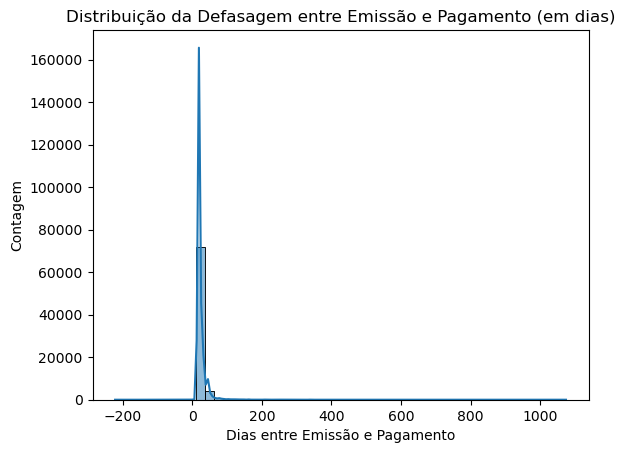

In [25]:
# Visualização da distribuição da defasagem entre emissão e pagamento (em dias)
base_dev['EMISSAO_PAGAMENTO_DIAS'] = (base_dev['DATA_PAGAMENTO'] - base_dev['DATA_EMISSAO_DOCUMENTO']).dt.days
sns.histplot(base_dev['EMISSAO_PAGAMENTO_DIAS'], bins=50, kde=True)
plt.title('Distribuição da Defasagem entre Emissão e Pagamento (em dias)')
plt.xlabel('Dias entre Emissão e Pagamento')
plt.ylabel('Contagem')

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\519662271.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  taxa_inad = base_dev.groupby('BUCKET_EMISSAO_PAGAMENTO')['INADIMPLENTE'].mean().reset_index()


Text(0.5, 1.0, 'Taxa de Inadimplência por Intervalo entre Emissão e Pagamento')

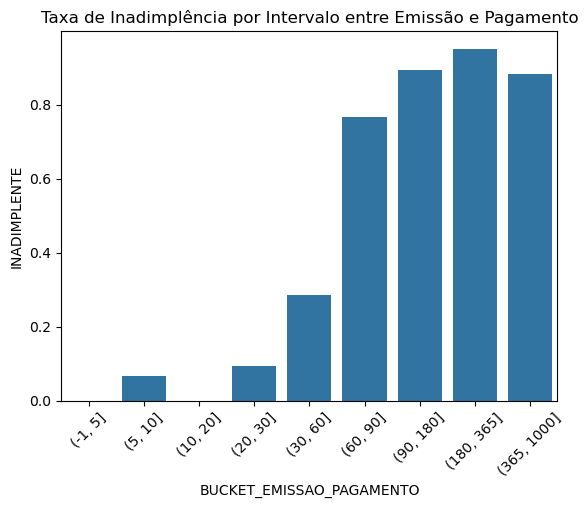

In [26]:
# Visualização da taxa de inadimplência por intervalo de tempo entre emissão e pagamento
base_dev['BUCKET_EMISSAO_PAGAMENTO'] = pd.cut(base_dev['EMISSAO_PAGAMENTO_DIAS'], bins=[-1, 5, 10, 20, 30, 60, 90, 180, 365, 1000])
taxa_inad = base_dev.groupby('BUCKET_EMISSAO_PAGAMENTO')['INADIMPLENTE'].mean().reset_index()
sns.barplot(data=taxa_inad, x='BUCKET_EMISSAO_PAGAMENTO', y='INADIMPLENTE')
plt.xticks(rotation=45)
plt.title('Taxa de Inadimplência por Intervalo entre Emissão e Pagamento')

Text(0.5, 1.0, 'Distribuição de Dias entre Emissão e Pagamento por Status de Inadimplência')

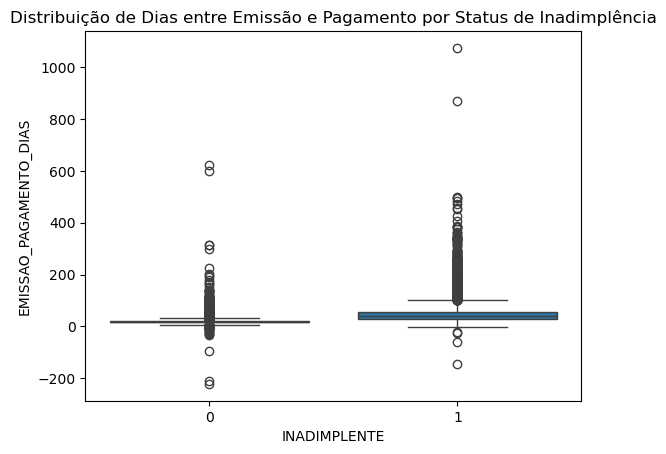

In [27]:
# Visualização da distribuição de dias entre emissão e pagamento por inadimplência
sns.boxplot(x='INADIMPLENTE', y='EMISSAO_PAGAMENTO_DIAS', data=base_dev)
plt.title('Distribuição de Dias entre Emissão e Pagamento por Status de Inadimplência')

Podemos observar que:

- A maioria dos pagamentos ocorre em um intervalo relativamente curto após a emissão do documento. No entanto, há casos extremos de longos atrasos, que merecem atenção por possivelmente estarem associados à inadimplência;

- Existe uma forte correlação positiva entre o número de dias entre emissão e pagamento e a inadimplência. Quanto maior esse intervalo, maior a chance de inadimplência;

- Clientes inadimplentes, em média, demoram significativamente mais para realizar o pagamento após a emissão. A presença de outliers nesse grupo sugere que alguns casos extremos podem estar influenciando negativamente o padrão geral de pagamento;

- Existem alguns casos extremos com diferença negativa entre a data de emissão do documento e a data de pagamento, inclusive entre clientes inadimplentes. Embora esse comportamento pareça contraditório, ele pode refletir particularidades do processo, como emissão retroativa após a confirmação de pagamento. Além disso, foi identificado um caso de inadimplência com diferença positiva de mais de 1000 dias entre emissão e pagamento, valor que também foge completamente do padrão observado e não se encaixa em nenhum intervalo da variável categórica BUCKET_EMISSAO_PAGAMENTO, indicando uma possível inconsistência ou situação atípica;
---
💡 Importante: Apesar da forte relação com inadimplência, todas as variáveis derivadas da data de pagamento foram utilizadas apenas para fins exploratórios e não serão incluídas na modelagem preditiva, uma vez que as informações de pagamento não estão disponíveis no conjunto de teste. Essa decisão visa garantir a validade do modelo em cenários reais de previsão, evitando o uso de informações não disponíveis no momento da decisão.

Outro ponto relevante que pode impactar a modelagem preditiva — especialmente em modelos lineares, como a Regressão Logística — é a presença de multicolinearidade entre variáveis independentes. Para investigar esse aspecto, será realizada uma análise de correlação entre as variáveis numéricas, a fim de identificar relações redundantes que possam comprometer a estabilidade e interpretabilidade do modelo.

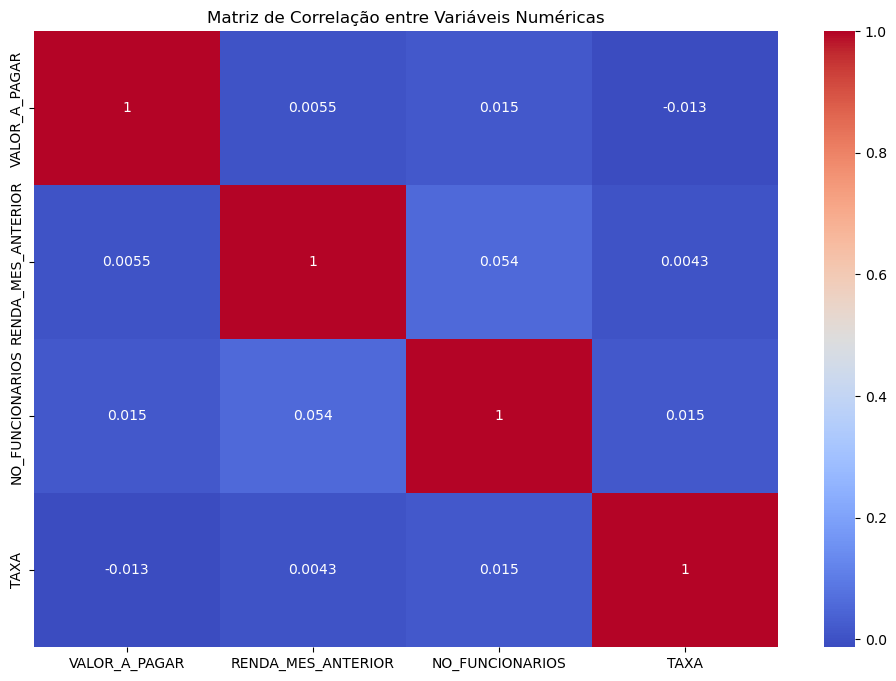

In [28]:
# visuzliação da correlação entre as variáveis numéricas
num_cols = ['VALOR_A_PAGAR', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'TAXA']
corr_matrix = base_dev[num_cols].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.show()

A análise da matriz de correlação entre as variáveis numéricas revela níveis bastante baixos de associação linear entre os atributos considerados. Isso indica uma baixa presença de multicolinearidade, o que é positivo para a construção dos modelos preditivos — especialmente para a Regressão Logística, que pode ser sensível a esse tipo de redundância entre variáveis. Com isso, não é necessária, neste momento, a eliminação de variáveis com base nesse critério.

## 3 - Modelagem

Com base na análise exploratória dos dados (EDA), foi possível identificar padrões relevantes associados à inadimplência, como o impacto da taxa de cobrança (TAXA), o comportamento de variáveis ao longo do tempo, e a ausência de problemas significativos de multicolinearidade entre os atributos numéricos. Essas observações fornecem uma base sólida para avançarmos à etapa de modelagem preditiva.

O objetivo agora é construir modelos capazes de estimar a probabilidade de inadimplência de cobranças futuras, com base nos registros disponíveis. Para isso, o processo de modelagem será estruturado em etapas bem definidas, visando tanto a robustez preditiva quanto a interpretabilidade dos resultados para suporte à tomada de decisão.

### Etapas da Modelagem
1. **Pré-processamento e Engenharia de Atributos**
    - Nesta etapa, serão criadas variáveis transformadas, como os logaritmos das variáveis numéricas, e realizados os ajustes finais nos dados para garantir compatibilidade com os algoritmos de machine learning.

2. **Modelagem e Busca de Hiperparâmetros**
    - Três modelos serão considerados: Regressão Logística (como benchmark), LightGBM e CatBoost. A busca pelos melhores hiperparâmetros será conduzida via RandomizedSearchCV, otimizando o desempenho preditivo com base nas métricas escolhidas.

3. **Avaliação e Interpretação dos Modelos**
    - Os modelos serão avaliados por meio de métricas que melhor capturam a natureza do problema. Como o objetivo é **prever a probabilidade de inadimplência**, com dados altamente desbalanceados, prioriza-se:

        - **AUC-ROC**: mede a capacidade do modelo em discriminar entre inadimplentes e adimplentes, independentemente do limiar de corte.

        - **Log Loss**: penaliza fortemente previsões mal calibradas, sendo ideal para avaliação de modelos probabilísticos.

    Além da performance preditiva, também será avaliada a **importância das variáveis**, para fins de geração de insights de negócio.

4. **Treinamento Final e Geração de Previsões**
    - O modelo selecionado será treinado com todos os dados da base de desenvolvimento e, em seguida, utilizado para gerar as previsões de probabilidade de inadimplência na base de teste.

### 2.1 - Pré-processamento

In [29]:
# definição das variáveis por tipo
cat_cols = ['SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 
            'PORTE', 'DDD', 'CEP_2_DIG', 
            'FLAG_PF', 'VALOR_A_PAGAR_NULO', 
            'RENDA_MES_ANTERIOR_NULO', 'NO_FUNCIONARIOS_NULO',
            ]

num_cols = ['VALOR_A_PAGAR', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'TAXA']
log_transform_cols = num_cols  # Todas as numéricas recebem log
drop_cols = ['VALOR_A_PAGAR', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'TAXA', 'ID_CLIENTE',
             'DATA_CADASTRO', 'DATA_VENCIMENTO', 'DATA_EMISSAO_DOCUMENTO']  

In [30]:
# criação de função para pré-processamento dos dados
def preprocess_data(df, apply_cat_encoding=False):
    """
    Gera um dataset processado, adicionando informações sobre a transformação 
    logarítimica das variáveis numéricas, para suavizar efeitos de outliers,
    além de codificação das variáveis categóricas quando pedido.

    Também separa os dados em treino e validação para a etapa de modelagem.

    Parâmetros:
        - df (pd.DataFrame): Dataframe contendo os dados.
        - apply_cat_enconding (bool): flag para identificar se haverá transformação
            das variáveis categóricas.

    Retorna:
        - X_train (pd.DataFrame): Features de treino.
        - y_train (pd.Series): Alvo de treino.
        - X_test (pd.DataFrame): Features de teste (validação).
        - y_test (pd.Series): Alvo de teste (validação).
    """

    df = df.copy()

    # Adição das informações de ano e mês
    df['ANO'] = df['SAFRA_REF'].dt.year.astype('int64')
    df['MES'] = df['SAFRA_REF'].dt.month.astype('int64')

    df.drop('SAFRA_REF', axis=1, inplace=True)

    # Tratamento de variáveis numéricas: log(1 + x)
    for col in log_transform_cols:
        df[f'log_{col}'] = np.log1p(df[col])

    # Remoção das variáveis originais numéricas (mantém só os log)
    df.drop(columns=drop_cols, inplace=True)

    # Codificação de variáveis categóricas se necessário
    if apply_cat_encoding:
        df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # Separar X e y   
    X = df.drop(columns='INADIMPLENTE')
    y = df['INADIMPLENTE']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        random_state=42,
                                                        test_size=.2,
                                                        stratify=y)

    return X_train, X_test, y_train, y_test


Como os modelos LightGBM e CatBoost lidam nativamente com variáveis categóricas, o conjunto de treino/validação para esses modelos manterá as categorias em seu formato original. Por outro lado, a Regressão Logística requer variáveis numéricas, então será utilizado um dataset distinto, com as variáveis categóricas transformadas via one-hot encoding.

In [31]:
# geração dos dados de treino e validação para regressão logística
X_train_lr, X_valid_lr, y_train_lr, y_valid_lr = preprocess_data(base_dev, apply_cat_encoding=True)

# geração dos dados de treino e validação para LightGBM e CatBoost
X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = preprocess_data(base_dev)

# Remoção das colunas com informação relacionadas à data de pagamento
X_train_lr.drop(columns=['DATA_PAGAMENTO',
             'EMISSAO_PAGAMENTO_DIAS', 'BUCKET_EMISSAO_PAGAMENTO'], inplace=True)

X_train_cat.drop(columns=['DATA_PAGAMENTO',
             'EMISSAO_PAGAMENTO_DIAS', 'BUCKET_EMISSAO_PAGAMENTO'], inplace=True)

X_valid_lr.drop(columns=['DATA_PAGAMENTO',
             'EMISSAO_PAGAMENTO_DIAS', 'BUCKET_EMISSAO_PAGAMENTO'], inplace=True)

X_valid_cat.drop(columns=['DATA_PAGAMENTO',
             'EMISSAO_PAGAMENTO_DIAS', 'BUCKET_EMISSAO_PAGAMENTO'], inplace=True)

### 2.2- Treinamento, predição e avaliação dos dados de treino e validação

In [32]:
# definição da função para avaliação dos modelos
def evaluate_model(model, X_test, y_test, name="Model"):
    """
    Avalia um modelo de classificação binária usando AUC-ROC e Log Loss.

    Parâmetros:
        model: O modelo de classificação treinado a ser avaliado.
               Deve ter um método `predict_proba` que retorna probabilidades
               para a classe positiva (geralmente a segunda coluna).
        X_test: Os dados de teste (features).
        y_test: Os rótulos verdadeiros para os dados de teste.
        name (str, optional): O nome do modelo para exibição na saída.
                              Padrão é "Model".

    Retorna:
        tuple: Uma tupla contendo:
            - auc (float): O valor da métrica AUC-ROC do modelo.
            - logloss (float): O valor da métrica Log Loss do modelo.
    """
    # Prever as probabilidades para a classe positiva
    proba = model.predict_proba(X_test)[:, 1]

    # Cálculp a métrica AUC-ROC
    auc = roc_auc_score(y_test, proba)

    # Cálculo a métrica Log Loss
    logloss = log_loss(y_test, proba)

    print(f"{name}:\n  AUC-ROC: {auc:.4f}\n  Log Loss: {logloss:.4f}\n")
    return auc, logloss

Para avaliar a performance dos modelos preditivos, foram adotadas métricas adequadas ao contexto do problema, levando em consideração a natureza desbalanceada da variável alvo (INADIMPLENTE), onde apenas cerca de 7% dos registros representam inadimplência.

As principais métricas utilizadas são:

- **AUC-ROC (Área sob a curva ROC)**: mede a capacidade do modelo em distinguir corretamente entre classes (inadimplente vs adimplente) em diferentes limiares de decisão. Por ser uma métrica independente do threshold, ela é particularmente adequada em cenários desbalanceados e permite comparar modelos de forma justa.

- **Log Loss (Logaritmic Loss)**: avalia a calibração das probabilidades previstas. Penaliza previsões com alta confiança e incorretas. É útil quando o objetivo é prever a **probabilidade de inadimplência**, e não apenas classificar binariamente.

Essa dupla de métricas permite capturar tanto a **discriminatividade** (via AUC) quanto a **confiabilidade probabilística** (via Log Loss) dos modelos.

Além disso, para modelos que lidam com classificações desbalanceadas, foi adotado o uso de **pesos de classe**, atribuindo maior peso à classe minoritária (inadimplentes), de modo a reduzir o viés do modelo em favor da classe majoritária.

A função de avaliação personalizada foi construída para calcular essas métricas de maneira uniforme para todos os modelos, promovendo uma comparação clara e objetiva entre as abordagens testadas.

### 2.2.1 - Regressão Logística

In [33]:
# Pipeline para Regressão Logística
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', class_weight={0: 1, 1: 13}, random_state=42))
])

param_dist_lr = {
    'clf__C': [0.01, 0.1, 1]
}

search_lr = RandomizedSearchCV(pipe_lr, param_distributions=param_dist_lr,
                               n_iter=10, cv=3, scoring='roc_auc', random_state=42)
search_lr.fit(X_train_lr, y_train_lr)

# avaliação em treino e validação
print('---------Regressão Logística---------')
print('\nMelhores hiperparâmetros:', search_lr.best_params_)
print('\nResultados em treino')
evaluate_model(search_lr.best_estimator_, X_train_lr, y_train_lr, "Logistic Regression")
print('\nResultados em validação')
evaluate_model(search_lr.best_estimator_, X_valid_lr, y_valid_lr, "Logistic Regression")

c:\Users\vinic\anaconda3\envs\case_ds\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


---------Regressão Logística---------

Melhores hiperparâmetros: {'clf__C': 0.01}

Resultados em treino
Logistic Regression:
  AUC-ROC: 0.8814
  Log Loss: 0.4300


Resultados em validação
Logistic Regression:
  AUC-ROC: 0.8755
  Log Loss: 0.4339



(0.8754810379966018, 0.4338577783912772)

### 2.2.2 - CatBoost

In [34]:
# CatBoost
cat_model = CatBoostClassifier(class_weights=[1, 13], random_state=42, cat_features=cat_cols,
                               verbose=0)

param_dist_cat = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 500],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}

search_cat = RandomizedSearchCV(
    cat_model,
    param_distributions=param_dist_cat,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

search_cat.fit(X_train_cat, y_train_cat)

# avaliação em treino e validação
print('---------CatBoost---------')
print('\nMelhores hiperparâmetros:', search_cat.best_params_)
print('\nResultados em treino')
evaluate_model(search_cat.best_estimator_, X_train_cat, y_train_cat, "CatBoost")
print('\nResultados em validação')
evaluate_model(search_cat.best_estimator_, X_valid_cat, y_valid_cat, "CastBoost")

---------CatBoost---------

Melhores hiperparâmetros: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 8, 'border_count': 64}

Resultados em treino
CatBoost:
  AUC-ROC: 0.9816
  Log Loss: 0.1904


Resultados em validação
CastBoost:
  AUC-ROC: 0.9544
  Log Loss: 0.2155



(0.9543711416311338, 0.21552923864508397)

### 2.2.3 - LightGBM

In [35]:
# LightGBM
lgbm_model = LGBMClassifier(class_weight={0:1, 1:13}, random_state=42,
                               )

param_dist_lgbm = {
    'num_leaves': [20, 30, 50],
    'max_depth': [3, 5, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150]
}

search_lgbm = RandomizedSearchCV(
    lgbm_model,
    param_distributions=param_dist_lgbm,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=1
)

search_lgbm.fit(X_train_cat, y_train_cat)

# avaliação em treino e validação
print('---------LightGBM---------')
print('\nMelhores hiperparâmetros:', search_lgbm.best_params_)
print('\nResultados em treino')
evaluate_model(search_lgbm.best_estimator_, X_train_cat, y_train_cat, "LightGBM")
print('\nResultados em validação')
evaluate_model(search_lgbm.best_estimator_, X_valid_cat, y_valid_cat, "LightGBM")

[LightGBM] [Info] Number of positive: 2899, number of negative: 38387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 41286, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495399 -> initscore=-0.018404
[LightGBM] [Info] Start training from score -0.018404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2900, number of negative: 38387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_row_wise=true` to remove t

(0.9442669472993239, 0.2505362375530513)


### Comparativo entre Modelos

| Modelo                 | AUC-ROC (Treino) | Log Loss (Treino) | AUC-ROC (Validação) | Log Loss (Validação) |
|------------------------|------------------|--------------------|----------------------|------------------------|
| Regressão Logística    | 0.8814           | 0.4300             | 0.8755               | 0.4339                 |
| LightGBM               | 0.9762           | 0.2261             | 0.9443               | 0.2505                 |
| CatBoost               | 0.9816           | 0.1904             | **0.9544**           | **0.2155**             |

---

### Conclusões sobre os modelos

- O **CatBoost** apresentou o melhor desempenho, tanto em AUC-ROC quanto em Log Loss na validação, sendo o modelo mais eficaz para o problema.
- O **LightGBM** também apresentou excelente performance, com resultados muito próximos, sendo uma boa alternativa com menor tempo de treinamento.
- A **Regressão Logística** teve performance inferior, mas ainda satisfatória. Sua principal vantagem é a interpretabilidade dos coeficientes, sendo útil como baseline ou ferramenta de apoio na análise.

Com base nos resultados, o **modelo CatBoost será adotado para a previsão da probabilidade de inadimplência**, dado seu ótimo desempenho em discriminação e calibração.

Após o treinamento dos modelos preditivos, é fundamental entender quais variáveis mais influenciam na previsão de inadimplência. Essa análise de importância das variáveis (feature importance) tem dois objetivos principais:

1. **Interpretação do Modelo**: Identificar os principais fatores associados ao risco de inadimplência, fornecendo maior transparência ao processo de decisão automatizado.
2. **Geração de Insights de Negócio**: Compreender quais características dos clientes, cobranças ou comportamento financeiro impactam mais no risco, permitindo ações mais direcionadas na gestão de crédito.

A seguir, analisamos as variáveis mais relevantes segundo o modelo **CatBoost**, que apresentou o melhor desempenho preditivo entre os modelos testados.

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\2801990163.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(20), x='Importance', y='Feature', palette='viridis')


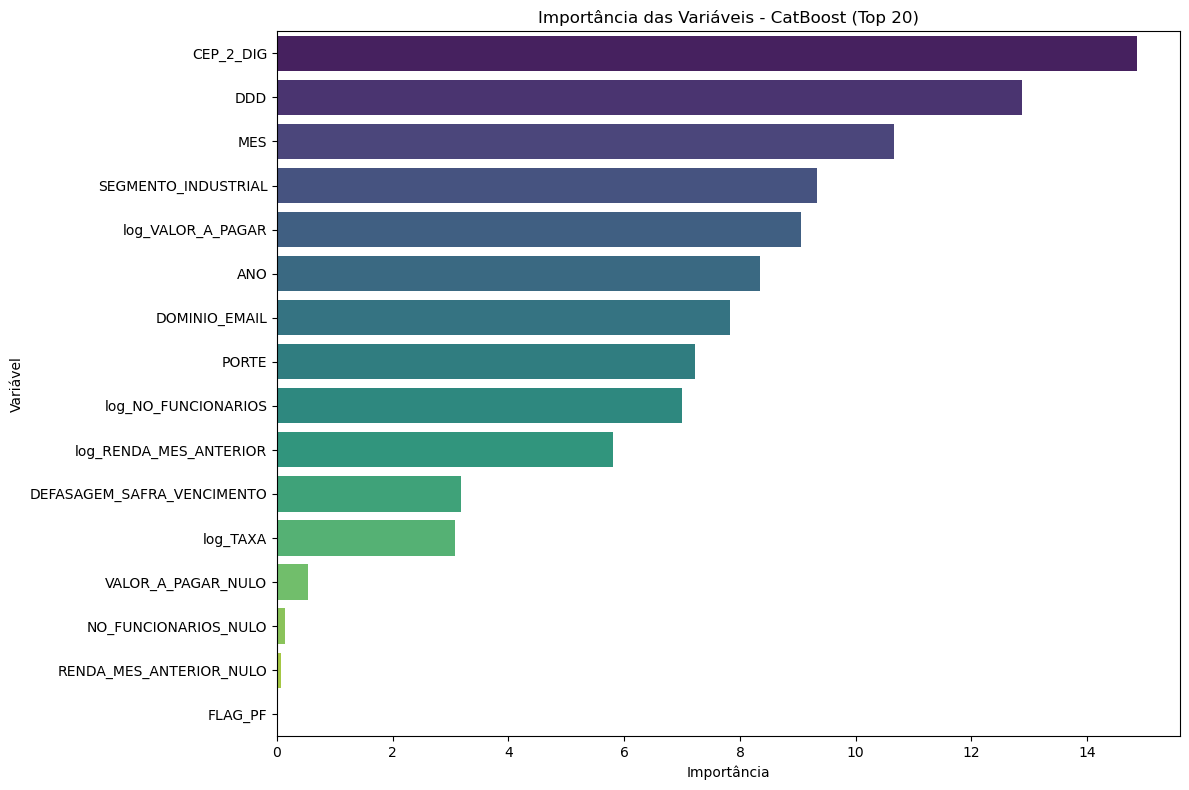

In [44]:
# Extração das informações de feature importance do modelo
cat_model = search_cat.best_estimator_
# Extrai os nomes das features e suas importâncias
feature_importance = cat_model.get_feature_importance()
feature_names = X_train_cat.columns

# Cria um DataFrame ordenado
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Visualização
plt.figure(figsize=(12, 8))
sns.barplot(data=feat_imp_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Importância das Variáveis - CatBoost (Top 20)')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()

A análise de importância das variáveis no modelo CatBoost revela os principais fatores associados à inadimplência. Os destaques são:

- A variável `CEP_2_DIG` se destaca com a maior importância no modelo. Isso sugere que a localização geográfica pode ter forte relação com o risco de inadimplência, possivelmente refletindo desigualdades regionais ou características socioeconômicas.

- O `DDD` também aparece como altamente relevante, reforçando a importância da localização, agora com base no código de área telefônico.

- Variáveis temporais como `MES` e `ANO` também figuram entre os principais preditores, indicando padrões sazonais ou variações no risco ao longo do tempo.

- A variável `log_VALOR_A_PAGAR` (valor do documento) mostra que o montante financeiro está relacionado ao risco, o que é esperado — valores mais altos podem estar associados a maior inadimplência.

- Informações de **perfil empresarial**, como `PORTE`, `SEGMENTO_INDUSTRIAL`, `log_NO_FUNCIONARIOS`, e `log_RENDA_MES_ANTERIOR`, também aparecem entre as variáveis mais importantes. Isso indica que aspectos estruturais da empresa influenciam o risco de inadimplência.

- Variáveis como `DOMINIO_EMAIL` (domínio do e-mail usado) apresentaram relevância intermediária. Isso pode refletir características de profissionalismo, uso de domínios genéricos vs. corporativos, entre outros fatores.

- A variável `DEFASAGEM_SAFRA_VENCIMENTO`, relacionada a atrasos sazonais, apresentou menor, mas ainda significativa, importância.

- Indicadores de valores ausentes, como `*_NULO`, e variáveis binárias como `FLAG_PF` mostraram baixa contribuição, o que é positivo do ponto de vista de robustez e confiabilidade do modelo.

## 4 - Previsão Final e Geração do Entregável
Após a análise exploratória, engenharia de variáveis, tratamento de inconsistências e comparação entre modelos, chegamos à etapa final do projeto. Nesta fase, o objetivo é treinar o modelo escolhido com todos os dados disponíveis (exceto o conjunto de teste), aplicar os mesmos tratamentos ao conjunto de teste e, por fim, gerar as previsões a serem entregues.

A seguir, realizamos:

- Re-treinamento do modelo final com os dados completos;

- Processamento do conjunto de teste com os mesmos critérios aplicados ao treino;

- Geração das probabilidades de inadimplência;

- Montagem do arquivo final com as previsões.

In [37]:
# Junção dos dados de treino e validação

X_full = pd.concat([X_train_cat, X_valid_cat], axis=0)
y_full = pd.concat([y_train_cat, y_valid_cat], axis=0)

In [38]:
# treinamento do modelo final

final_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    border_count=64,
    l2_leaf_reg=5,
    class_weights={0: 1, 1: 13},
    random_state=42,
    verbose=0,
    cat_features=cat_cols
)

final_model.fit(X_full, y_full)

In [39]:
# visualização das informações de teste
base_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12264 entries, 0 to 12263
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID_CLIENTE               12264 non-null  int64         
 1   SAFRA_REF                12264 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO   12264 non-null  datetime64[ns]
 3   DATA_VENCIMENTO          12264 non-null  datetime64[ns]
 4   VALOR_A_PAGAR            12264 non-null  float64       
 5   TAXA                     12264 non-null  float64       
 6   VALOR_A_PAGAR_NULO       12264 non-null  int64         
 7   DATA_CADASTRO            12226 non-null  datetime64[ns]
 8   DDD                      12226 non-null  category      
 9   FLAG_PF                  12226 non-null  float64       
 10  SEGMENTO_INDUSTRIAL      12226 non-null  category      
 11  DOMINIO_EMAIL            12226 non-null  category      
 12  PORTE                    12226 n

Podemos observar que 38 registros apresentam valores ausentes nas seguintes variáveis categóricas: `DDD`, `FLAG_PF`, `SEGMENTO_INDUSTRIAL`, `DOMINIO_EMAIL`, `PORTE` e `CEP_2_DIG`.

Como essas variáveis foram relevantes no modelo e os dados de teste não podem ser descartados, optamos por substituir os valores nulos por uma categoria explícita `"NULO"`. Apesar de essa categoria não ter aparecido na base de treino, o CatBoost lida corretamente com categorias inéditas durante a inferência, utilizando estimativas regularizadas para gerar previsões consistentes.

Essa abordagem garante integridade nos dados e compatibilidade com o modelo, sem comprometer a performance ou a interpretabilidade.


In [40]:
# Separação dos IDs dos clientes para adição à informação final das predições

ids = base_teste['ID_CLIENTE']

# Separação da SAFRA_REF para adição à informação final das predições

safra_ref = base_teste['SAFRA_REF']

In [41]:
# pré-processamento do conjunto de teste

base_teste['DEFASAGEM_SAFRA_VENCIMENTO'] = base_teste.apply(lambda x: diff_meses(x['SAFRA_REF'], x['DATA_VENCIMENTO']), axis=1)

# Adição das informações de ano e mês
base_teste['ANO'] = base_teste['SAFRA_REF'].dt.year.astype('int64')
base_teste['MES'] = base_teste['SAFRA_REF'].dt.month.astype('int64')

base_teste.drop('SAFRA_REF', axis=1, inplace=True)

# Tratamento de variáveis numéricas: log(1 + x)
for col in log_transform_cols:
    base_teste[f'log_{col}'] = np.log1p(base_teste[col])

# Remoção das variáveis originais numéricas (mantém só os log)
base_teste.drop(columns=drop_cols, inplace=True)

X_teste = base_teste[X_full.columns]
# Colunas categóricas com nulos
cols_categoricas_com_nulos = ['DDD', 'FLAG_PF', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG']

# Preencher com string "NULO"
for col in cols_categoricas_com_nulos:
    X_teste[col] = X_teste[col].astype(str)
    X_teste[col] = X_teste[col].fillna('NULO')

In [42]:
# Geração da probabilidade de inadimplência
test_preds = final_model.predict_proba(X_teste)[:, 1]

In [43]:
# geração do arquivo entregável
entrega = pd.DataFrame({
    'ID_CLIENTE': ids,
    'SAFRA_REF': safra_ref,
    'PROBABILIDADE_INADIMPLENCIA': test_preds
})

# Exportar para CSV
entrega.to_csv('submissao_case.csv', index=False)